In [33]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scFates as scf
import pySingleCellNet as pySCN
import onesc 
import igraph as ig
import networkx as nx

ig.config['plotting.backend'] = 'matplotlib'

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
sc.logging.print_header()

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


In [48]:
adata = sc.read_h5ad("/Users/ryang/Documents/Academics/Spring 2024/CSCB/Homework/HW5/ad_EpiMesoAPS_n500_032824.h5ad")
adata.shape

(1500, 29452)

# Part 1

In [49]:
gname_counts = adata.var_names.value_counts()
np.any(gname_counts>1)

False

In [50]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

<Axes: xlabel='total_counts', ylabel='n_cells_by_counts'>

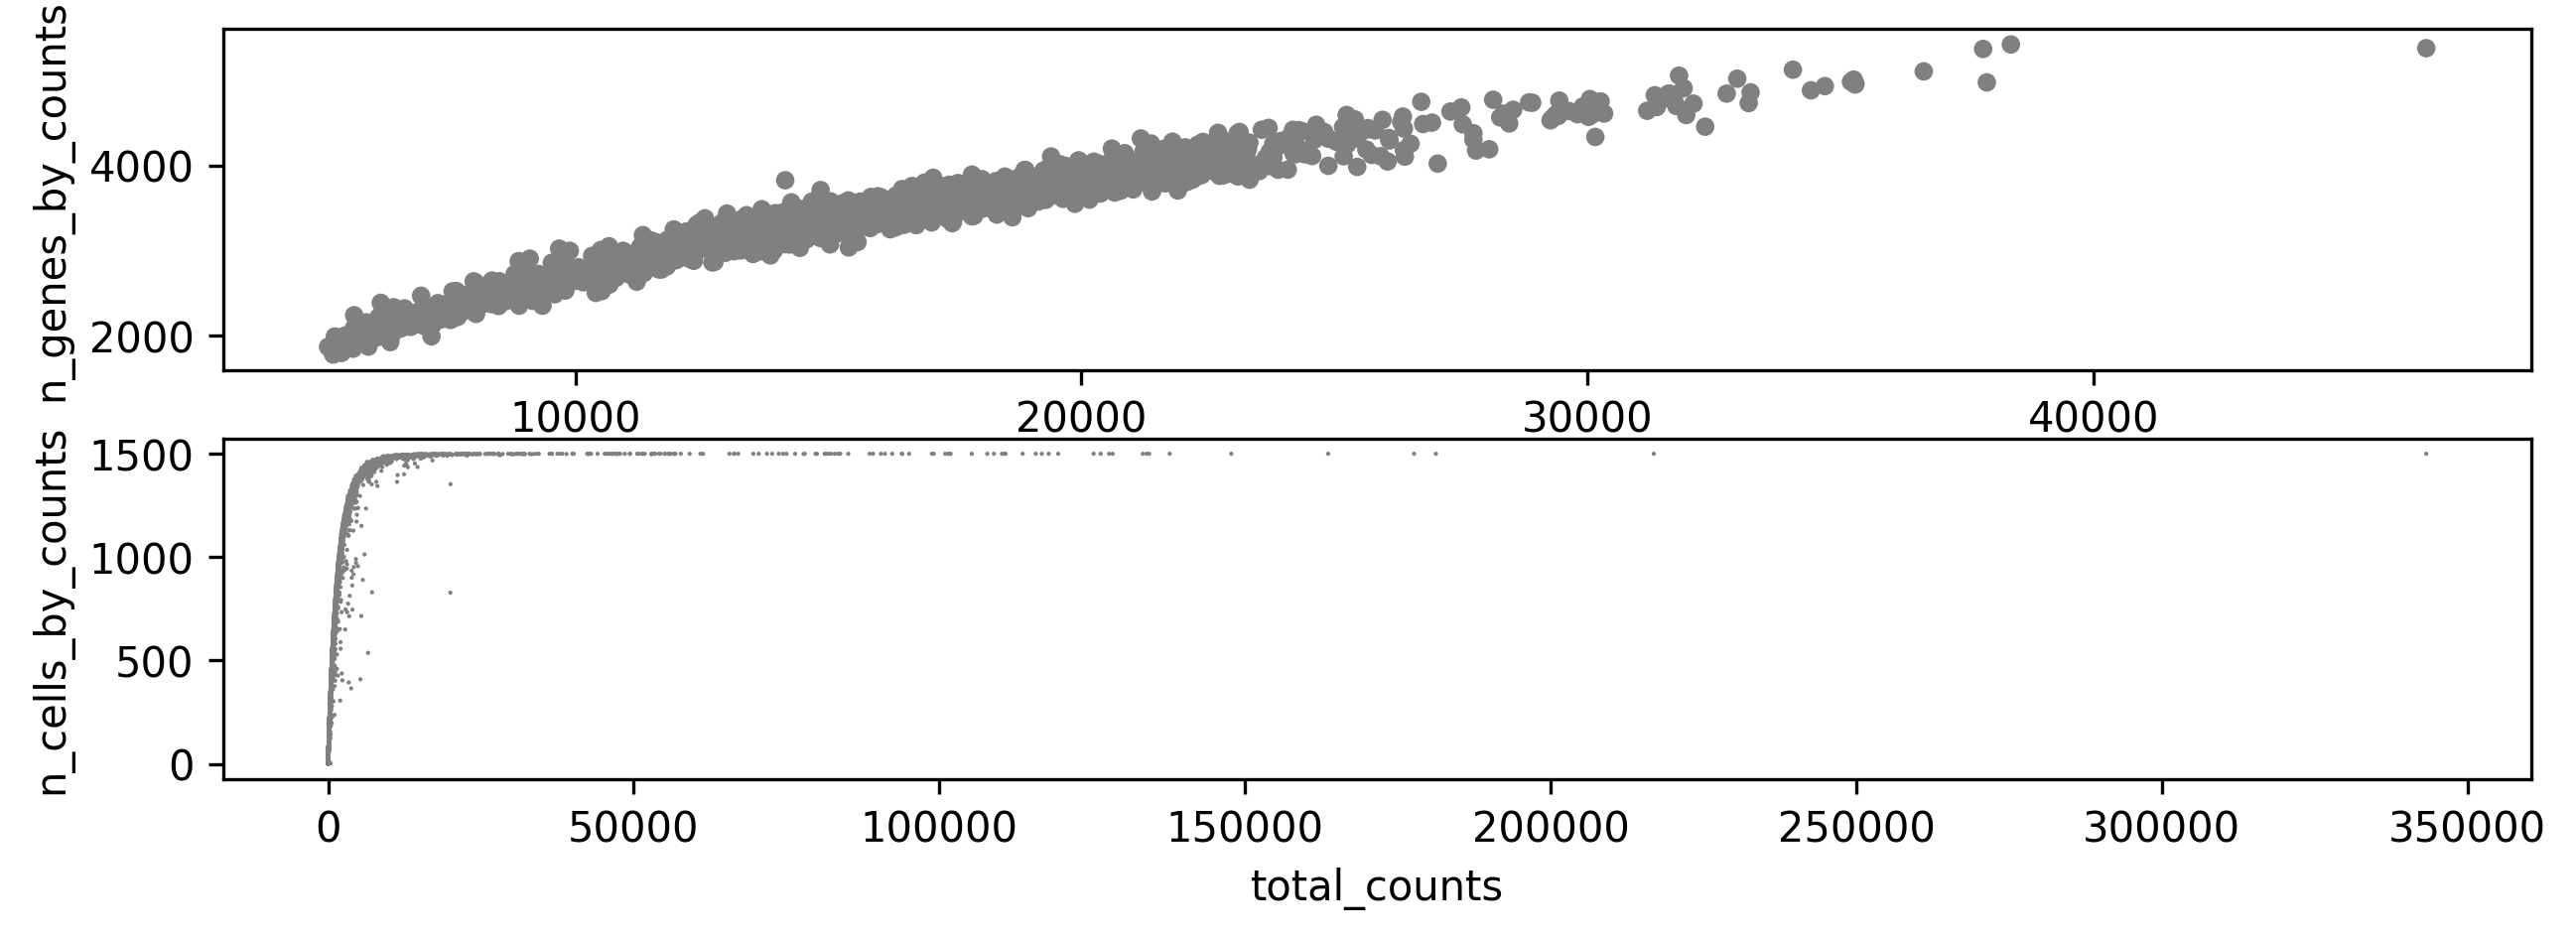

In [51]:
fig, ax = plt.subplots(2, figsize=(10,4), gridspec_kw={'wspace':0.25})
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',ax=ax[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_cells_by_counts',ax=ax[1], show=False)

In [52]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, max_counts=30000)
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape)

(1464, 14574)


<Axes: xlabel='total_counts', ylabel='n_cells_by_counts'>

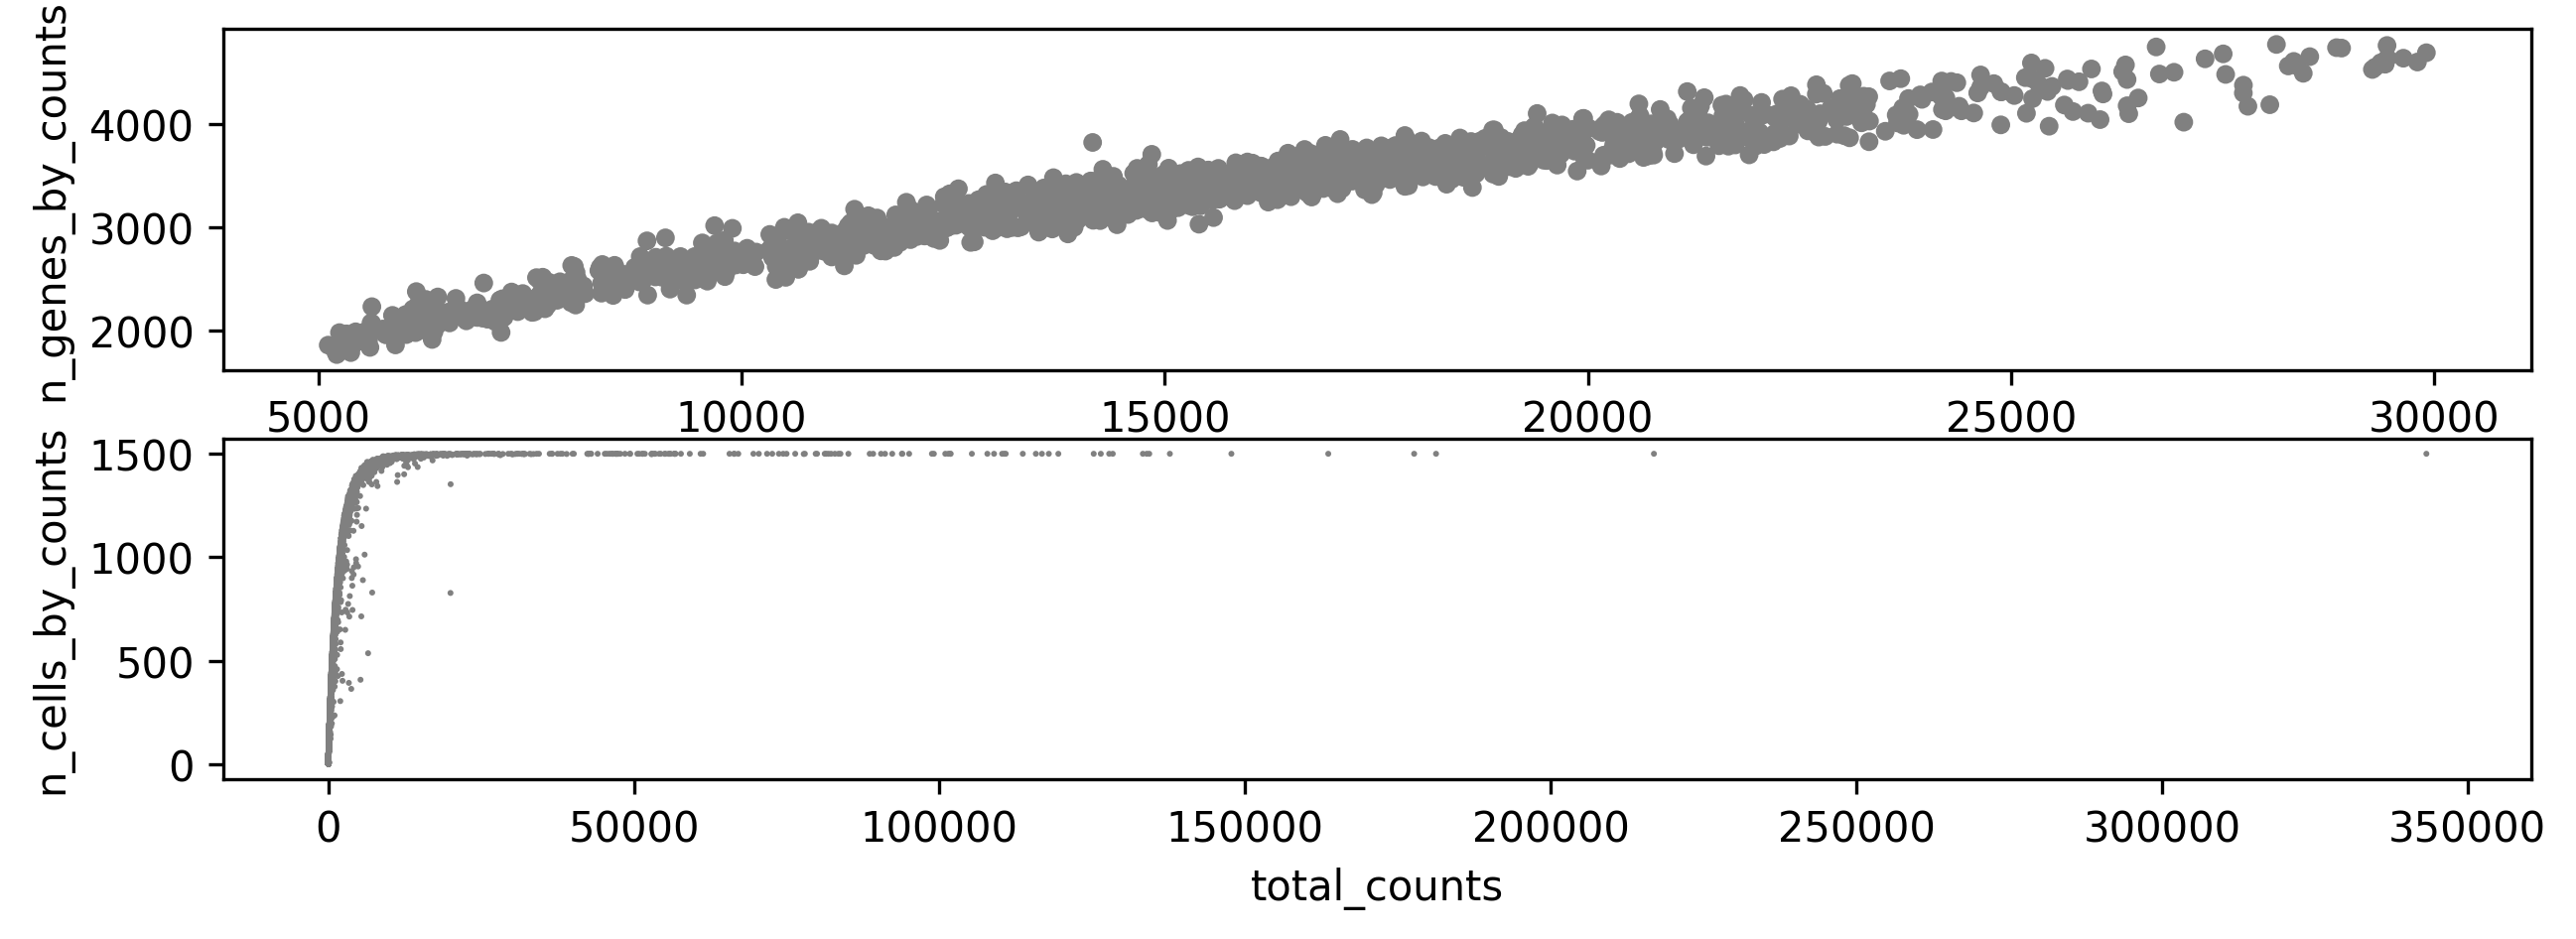

In [53]:
fig, ax = plt.subplots(2, figsize=(10,4), gridspec_kw={'wspace':0.25})
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',ax=ax[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_cells_by_counts',ax=ax[1], show=False)

In [54]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=6, min_disp=0.25)
sc.tl.pca(adata, use_highly_variable=True)

<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

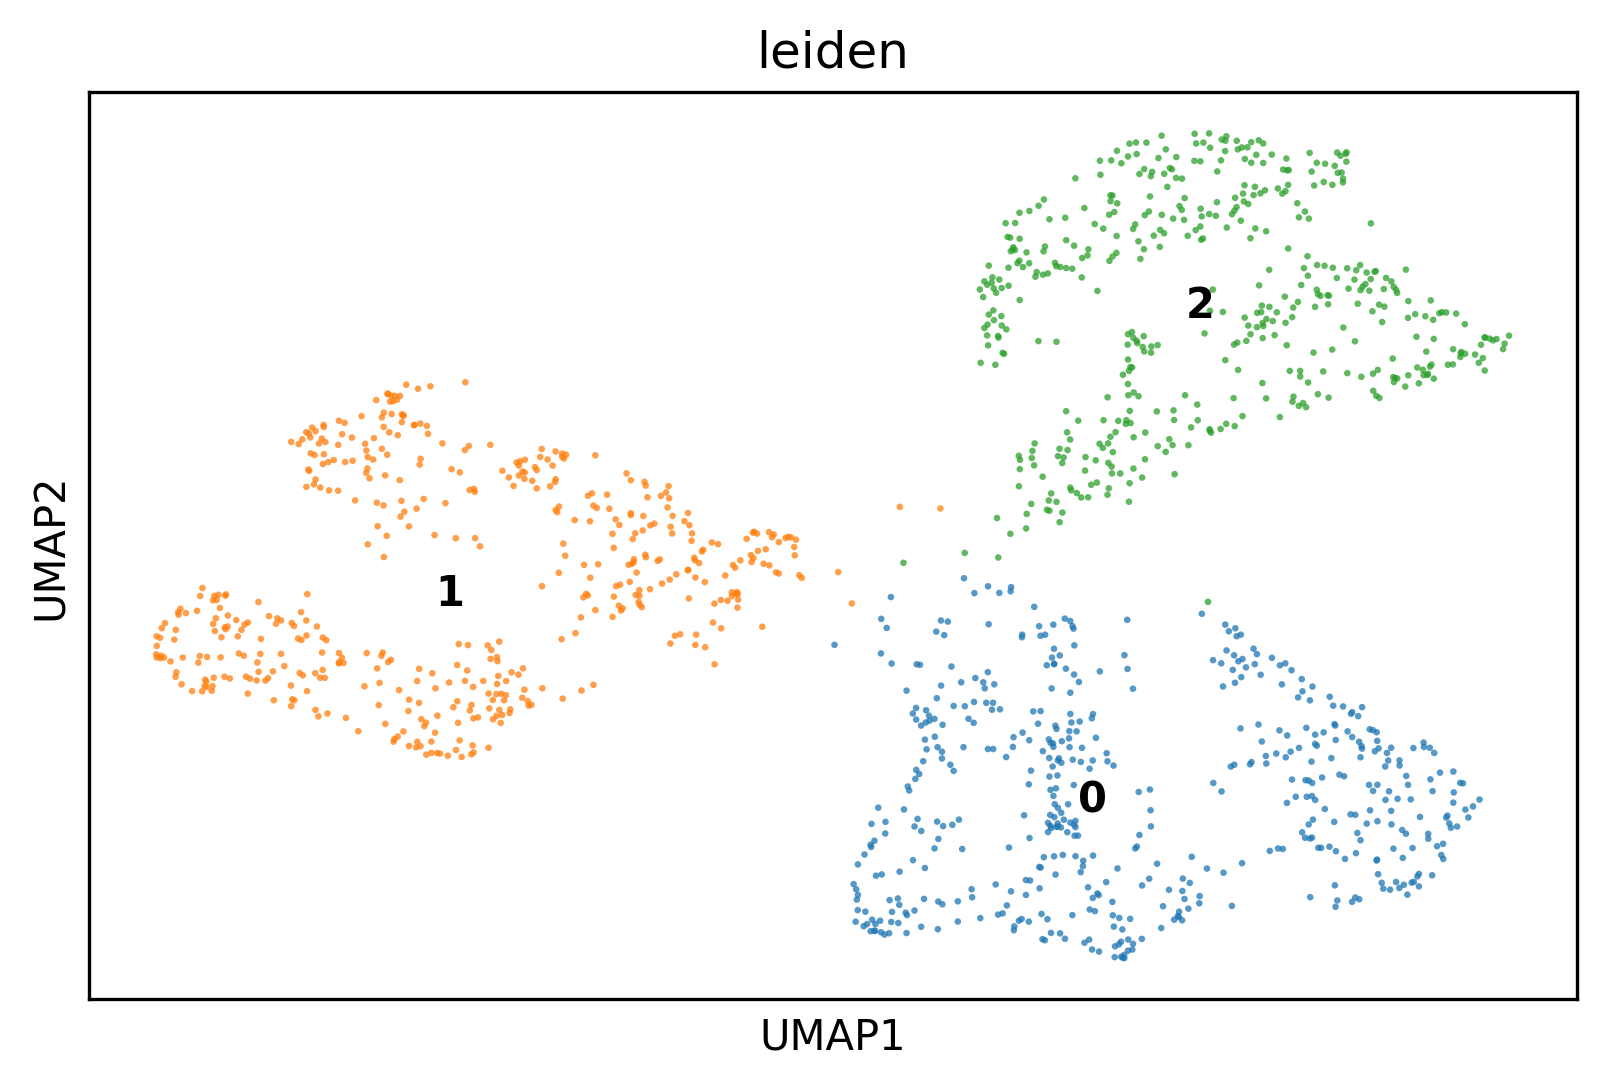

In [55]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=10)
sc.tl.leiden(adata, .1)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, 0.25, init_pos='paga')
sc.pl.umap(adata,color=['leiden'], alpha=.75, s=10, legend_loc='on data', show=False)

categories: 0, 1, 2
var_group_labels: Epiblast, Mesoderm, Anterior primitive streak


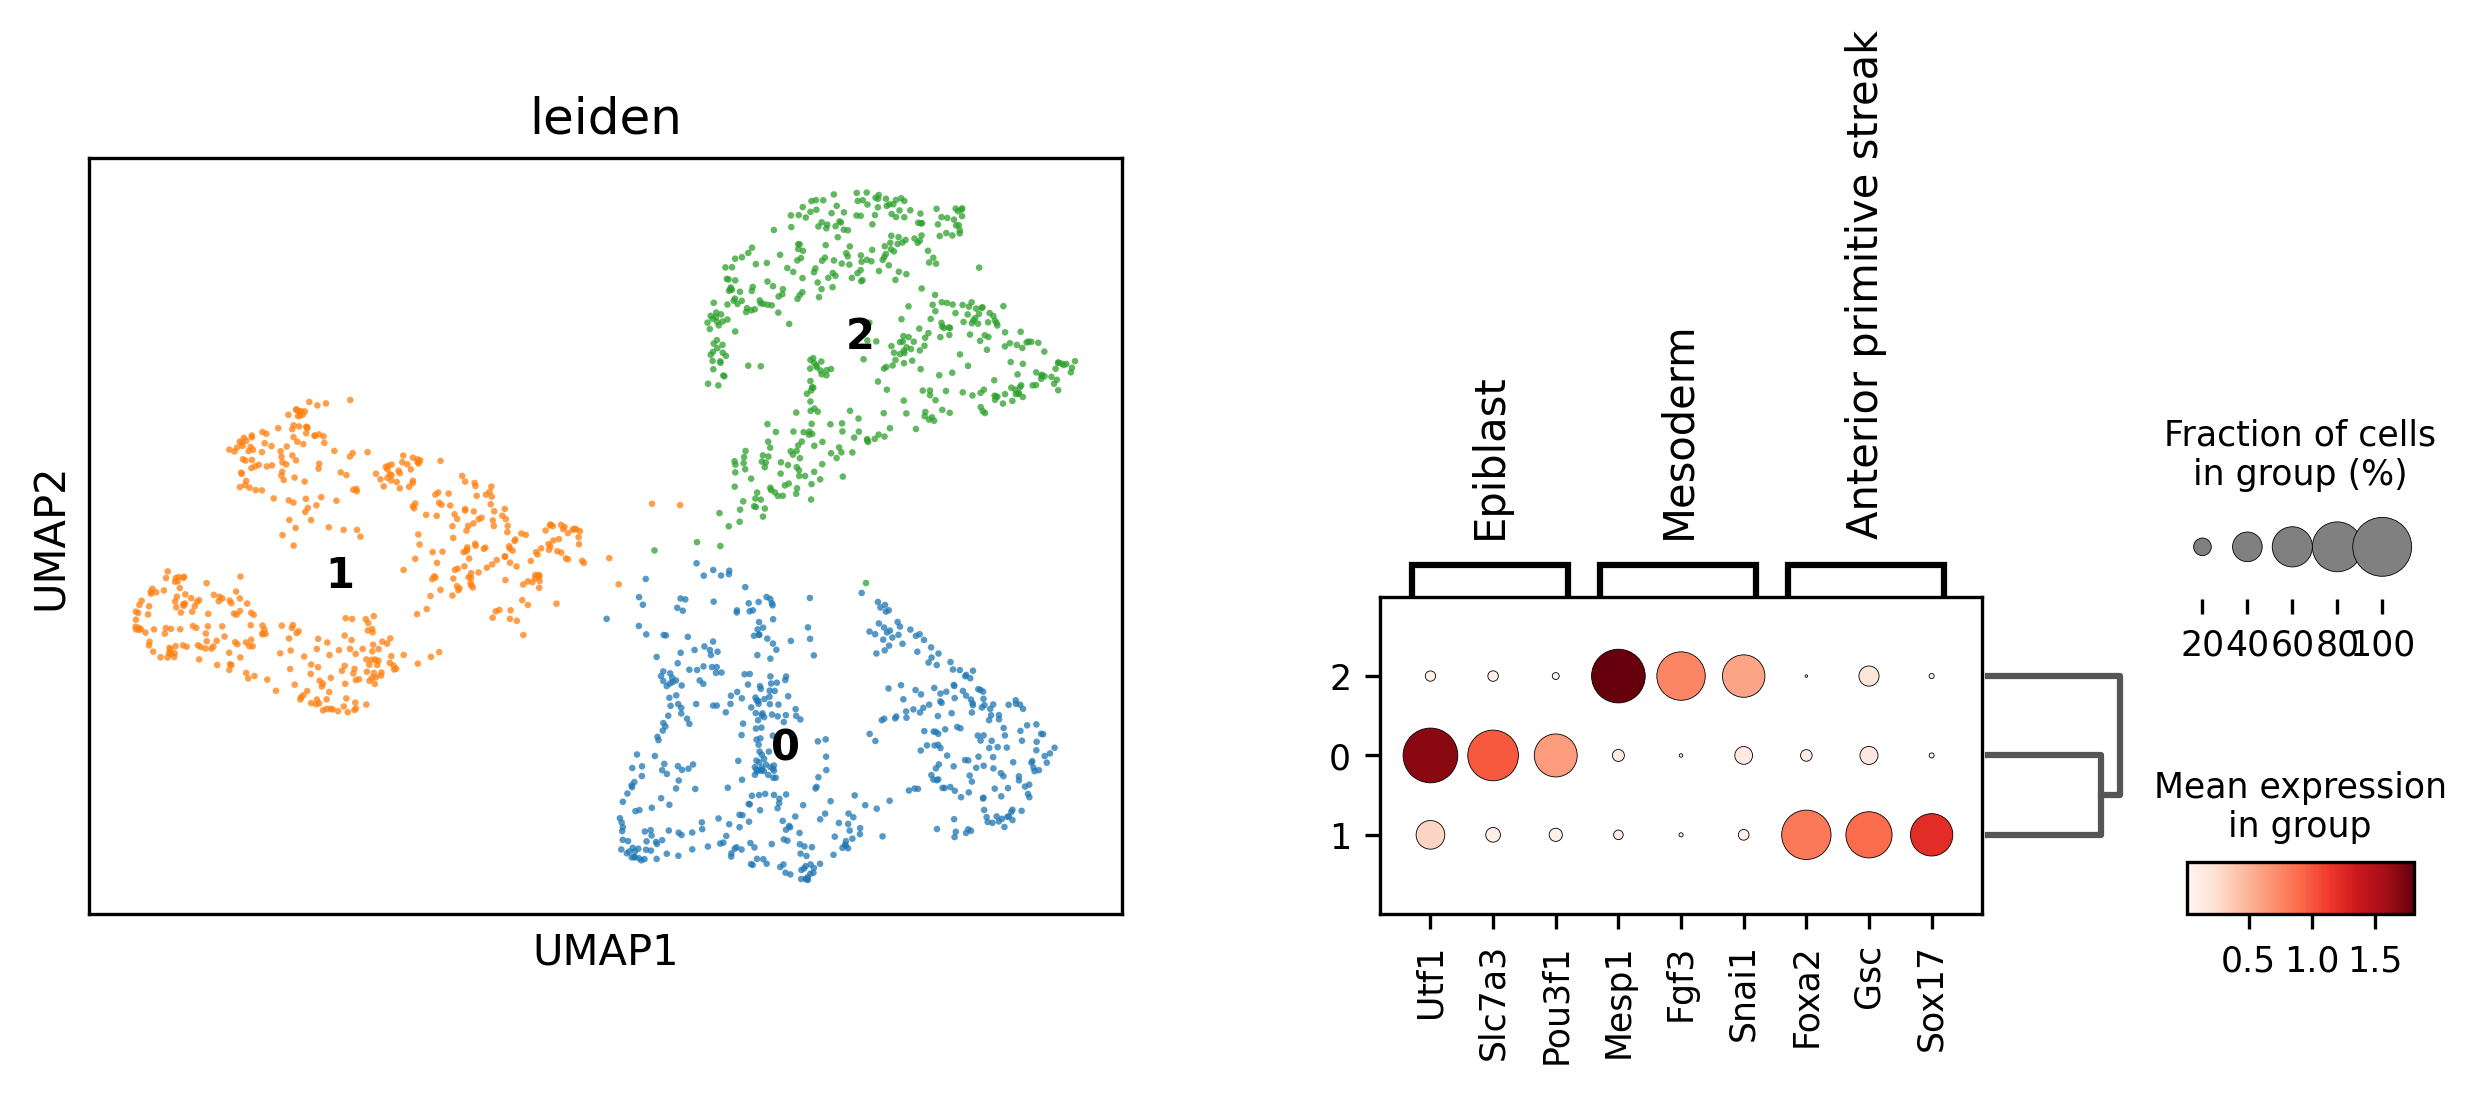

In [56]:
marker_genes_dict = {
    'Epiblast': ['Utf1', 'Slc7a3', 'Pou3f1'],
    'Mesoderm': ['Mesp1', 'Fgf3', 'Snai1'],
    'Anterior primitive streak': ['Foxa2', 'Gsc', 'Sox17'],
}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adata,color=['leiden'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adata, marker_genes_dict, 'leiden', dendrogram=True,ax=ax2, show=False)
plt.show()

In [57]:
cell_dict = {
    'Epiblast': ['0'],
    'Mesoderm': ['2'],
    'Anterior primitive streak': ['1'],
}

adata.obs['cell_types'] = np.nan

for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'cell_types'] = i

adata.obs['cell_types'] = adata.obs['cell_types'].astype("category")
adata.obs['cell_types']

cell_15                         Epiblast
cell_334                        Epiblast
cell_720                        Mesoderm
cell_1014                       Epiblast
cell_1142                       Mesoderm
                         ...            
cell_114559                     Mesoderm
cell_118969    Anterior primitive streak
cell_122647    Anterior primitive streak
cell_123152    Anterior primitive streak
cell_129498    Anterior primitive streak
Name: cell_types, Length: 1464, dtype: category
Categories (3, object): ['Anterior primitive streak', 'Epiblast', 'Mesoderm']

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.75, lambda = 100, metric = euclidean
    fitting:   0%|          | 0/100 [00:00<?, ?it/s]

    fitting:  28%|██▊       | 28/100 [00:01<00:05, 14.21it/s]
    converged
    finished (0:00:01) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


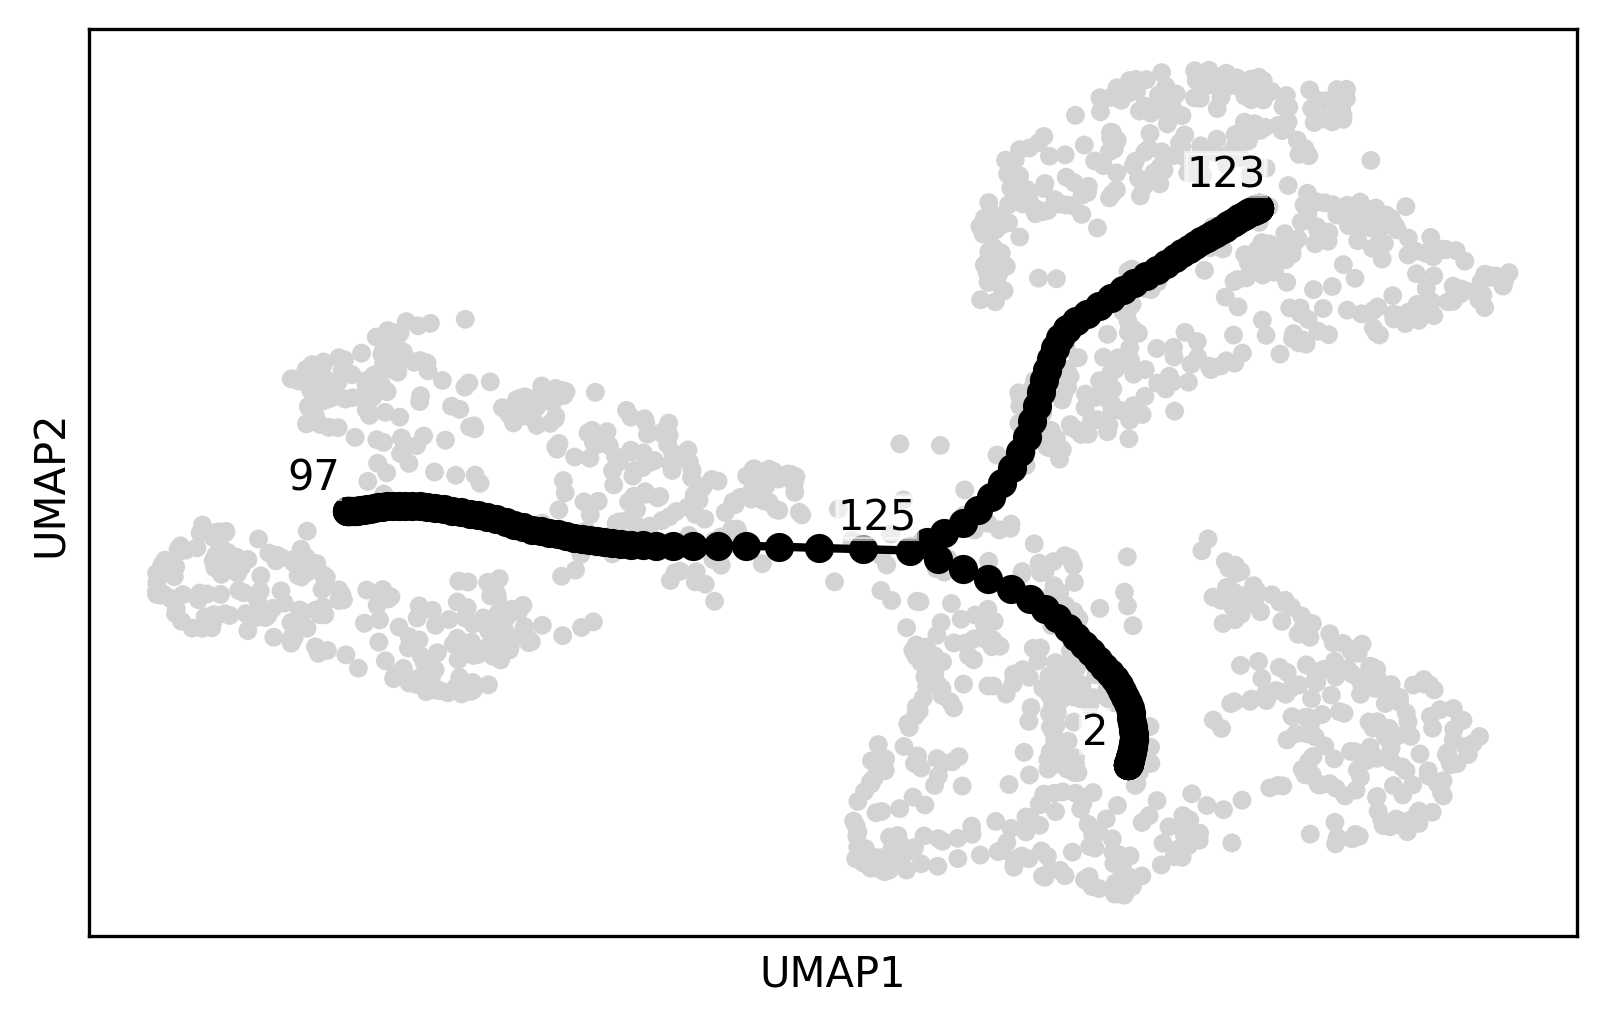

In [58]:
adT = adata.copy()
scf.tl.tree(adT,method="ppt",Nodes=200, ppt_sigma = 0.75, ppt_lambda = 100, ppt_nsteps=100, use_rep='X_pca', ndims_rep=2)      # Compute the tree
scf.pl.graph(adT, basis='umap')                                                                      # Plot the tree

| Milestone | Cluster |
| --------- | ------- |
|    2     | Epiblast|
|    125     | Bifurcation |
|   123     | Mesoderm |
|    97     | APS |

node 2 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


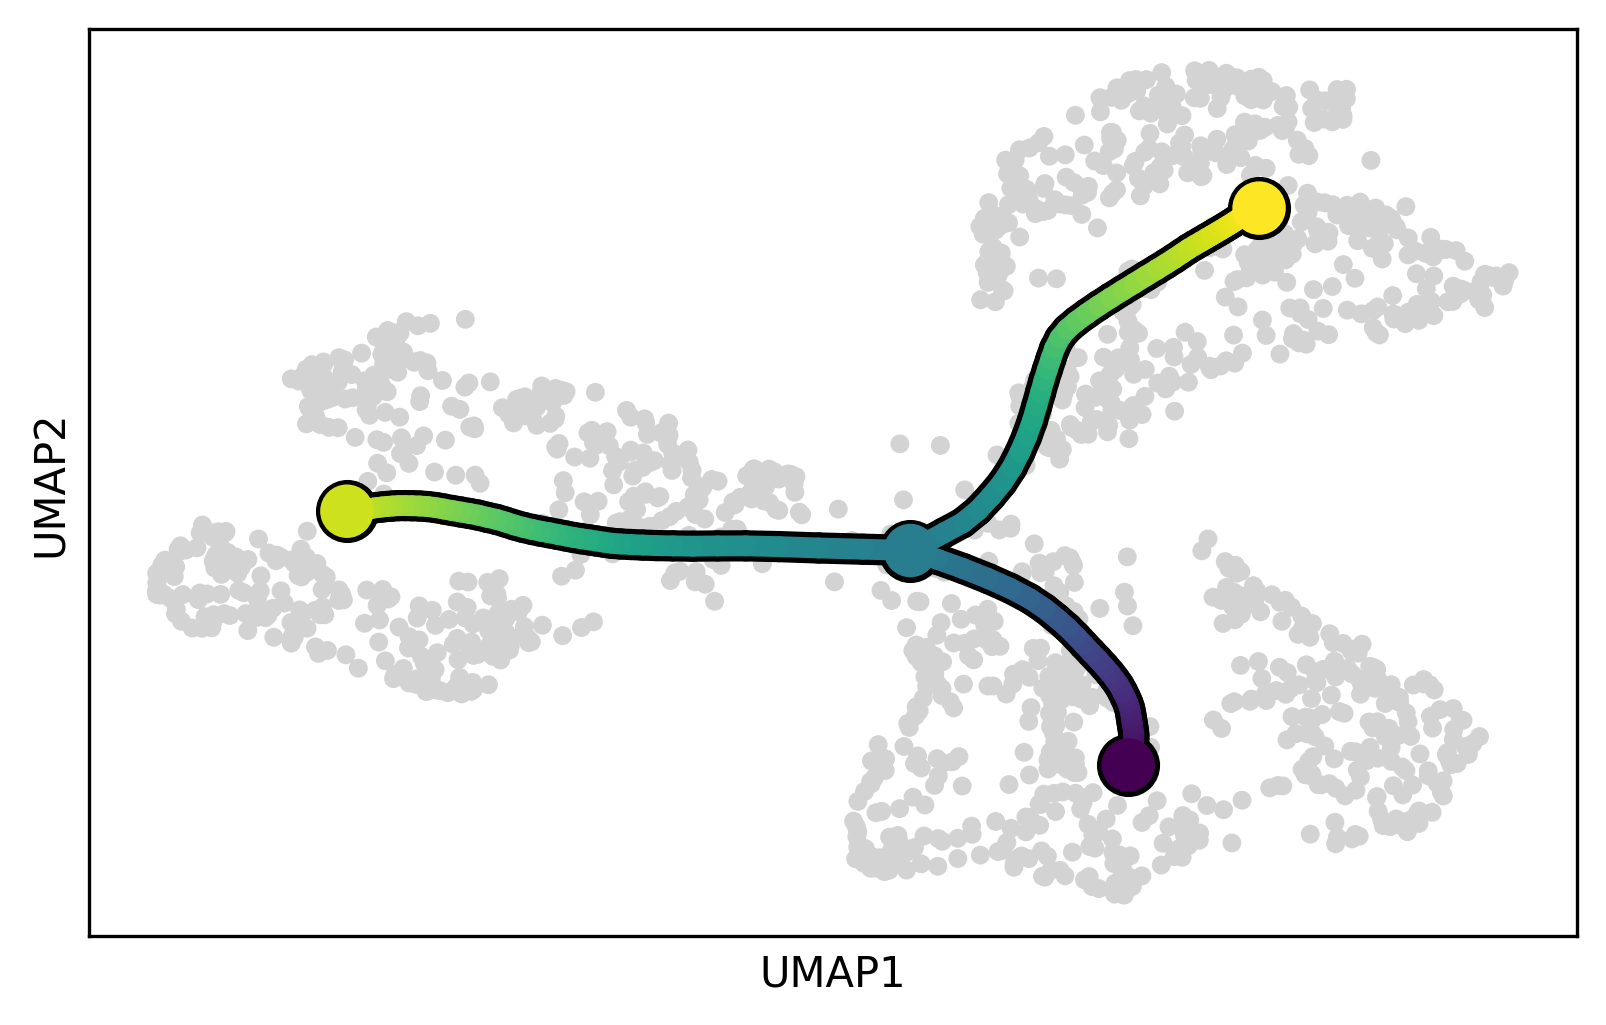

In [59]:
adTree = adT.copy()
scf.tl.root(adTree, root = 2)
scf.tl.pseudotime(adTree)
scf.pl.trajectory(adTree, basis = "umap")

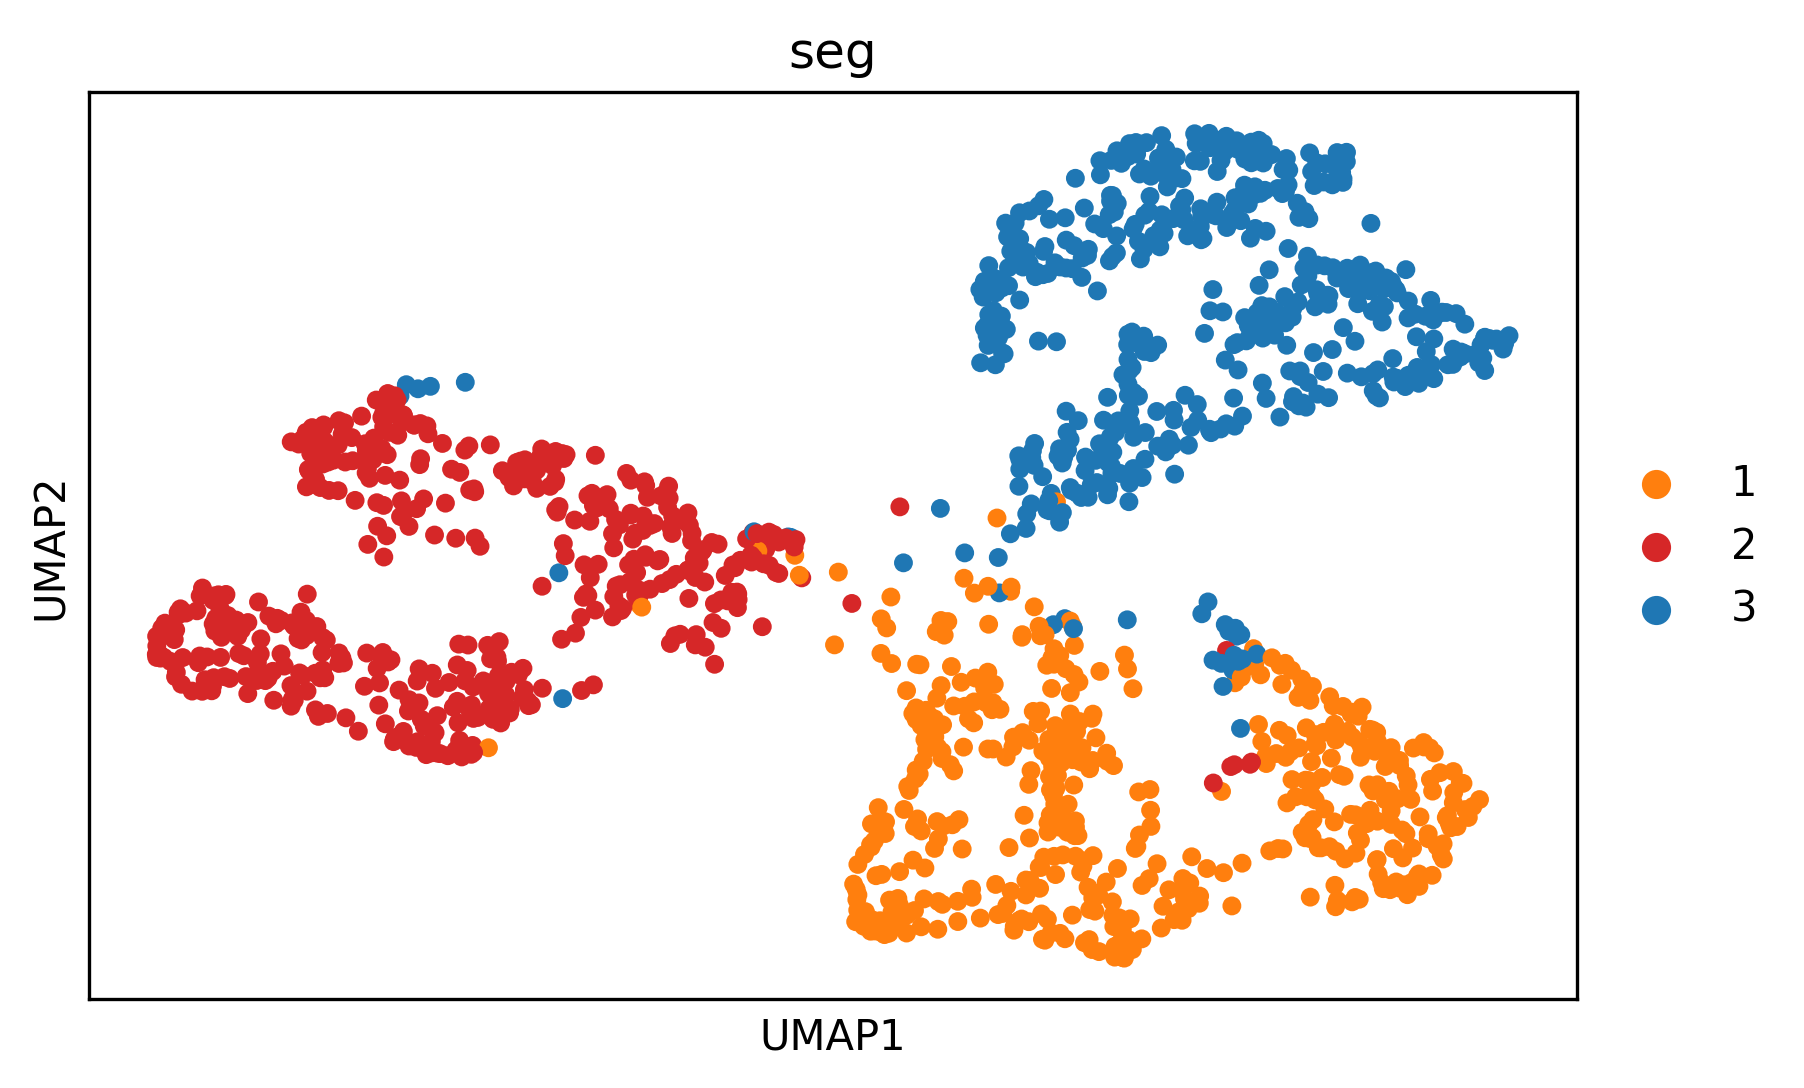

In [60]:
sc.pl.umap(adTree, color = 'seg')

Generating dendrogram of tree


    segment : 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]
    finished (0:00:00) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


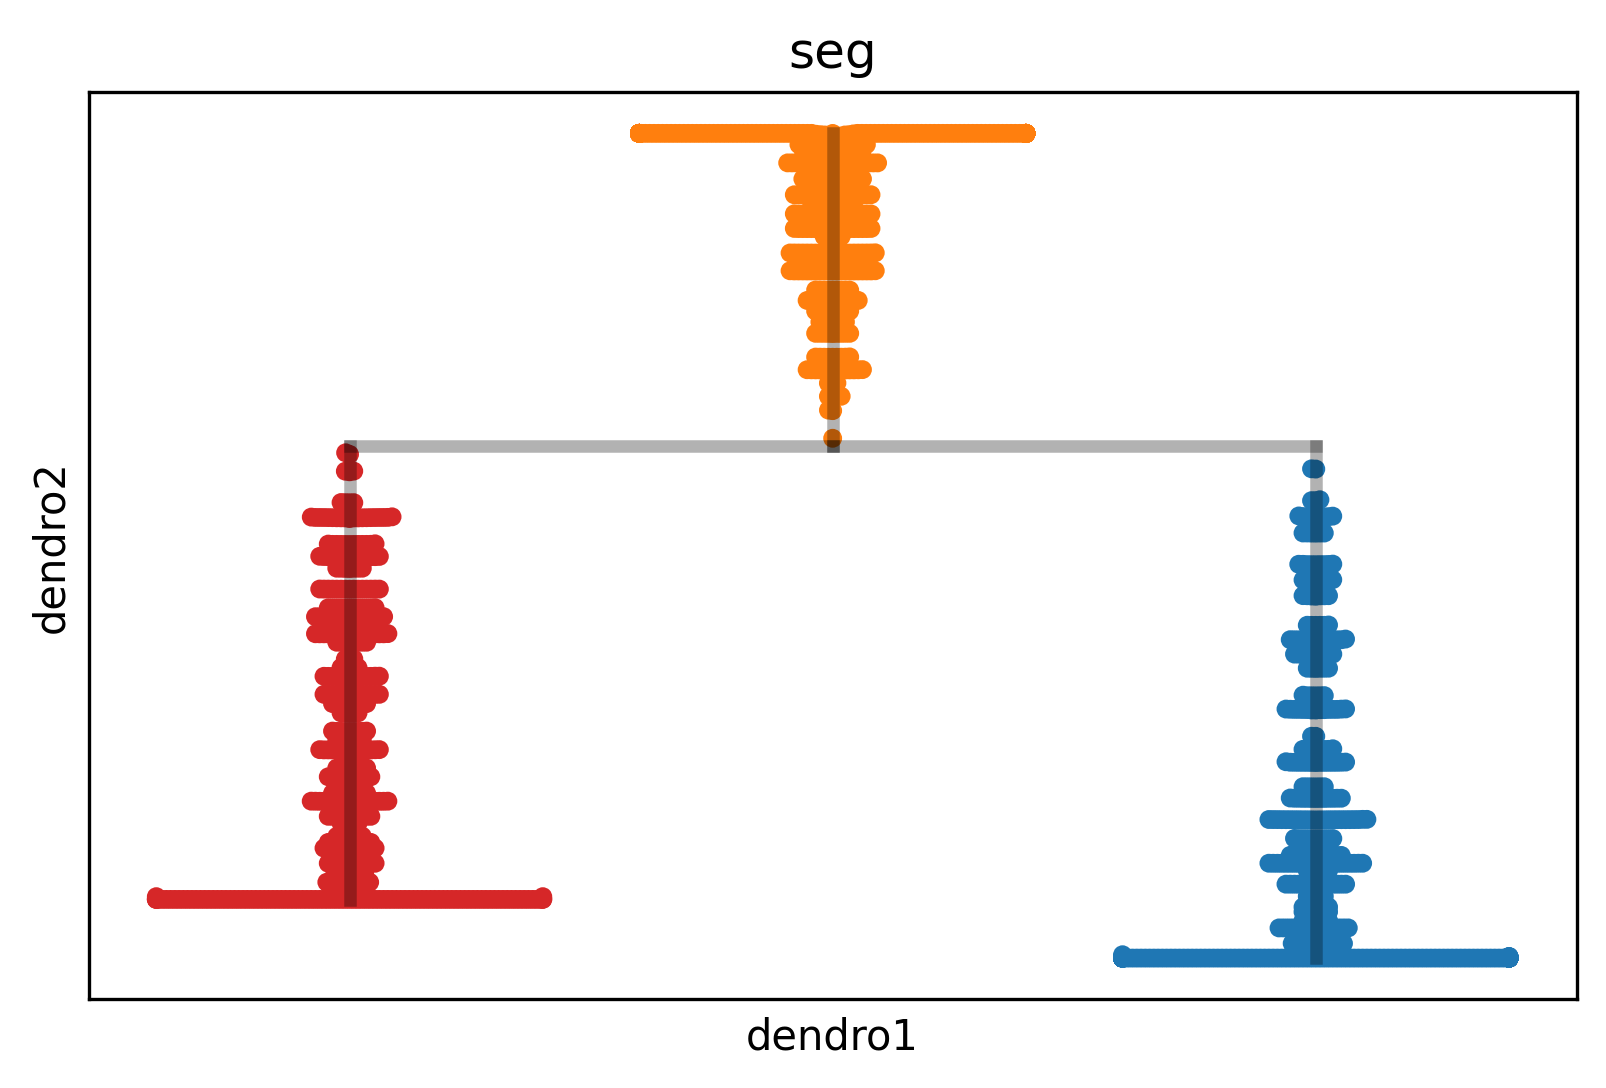

In [61]:
scf.tl.dendrogram(adTree)
scf.pl.dendrogram(adTree,color="seg",show_info=False)

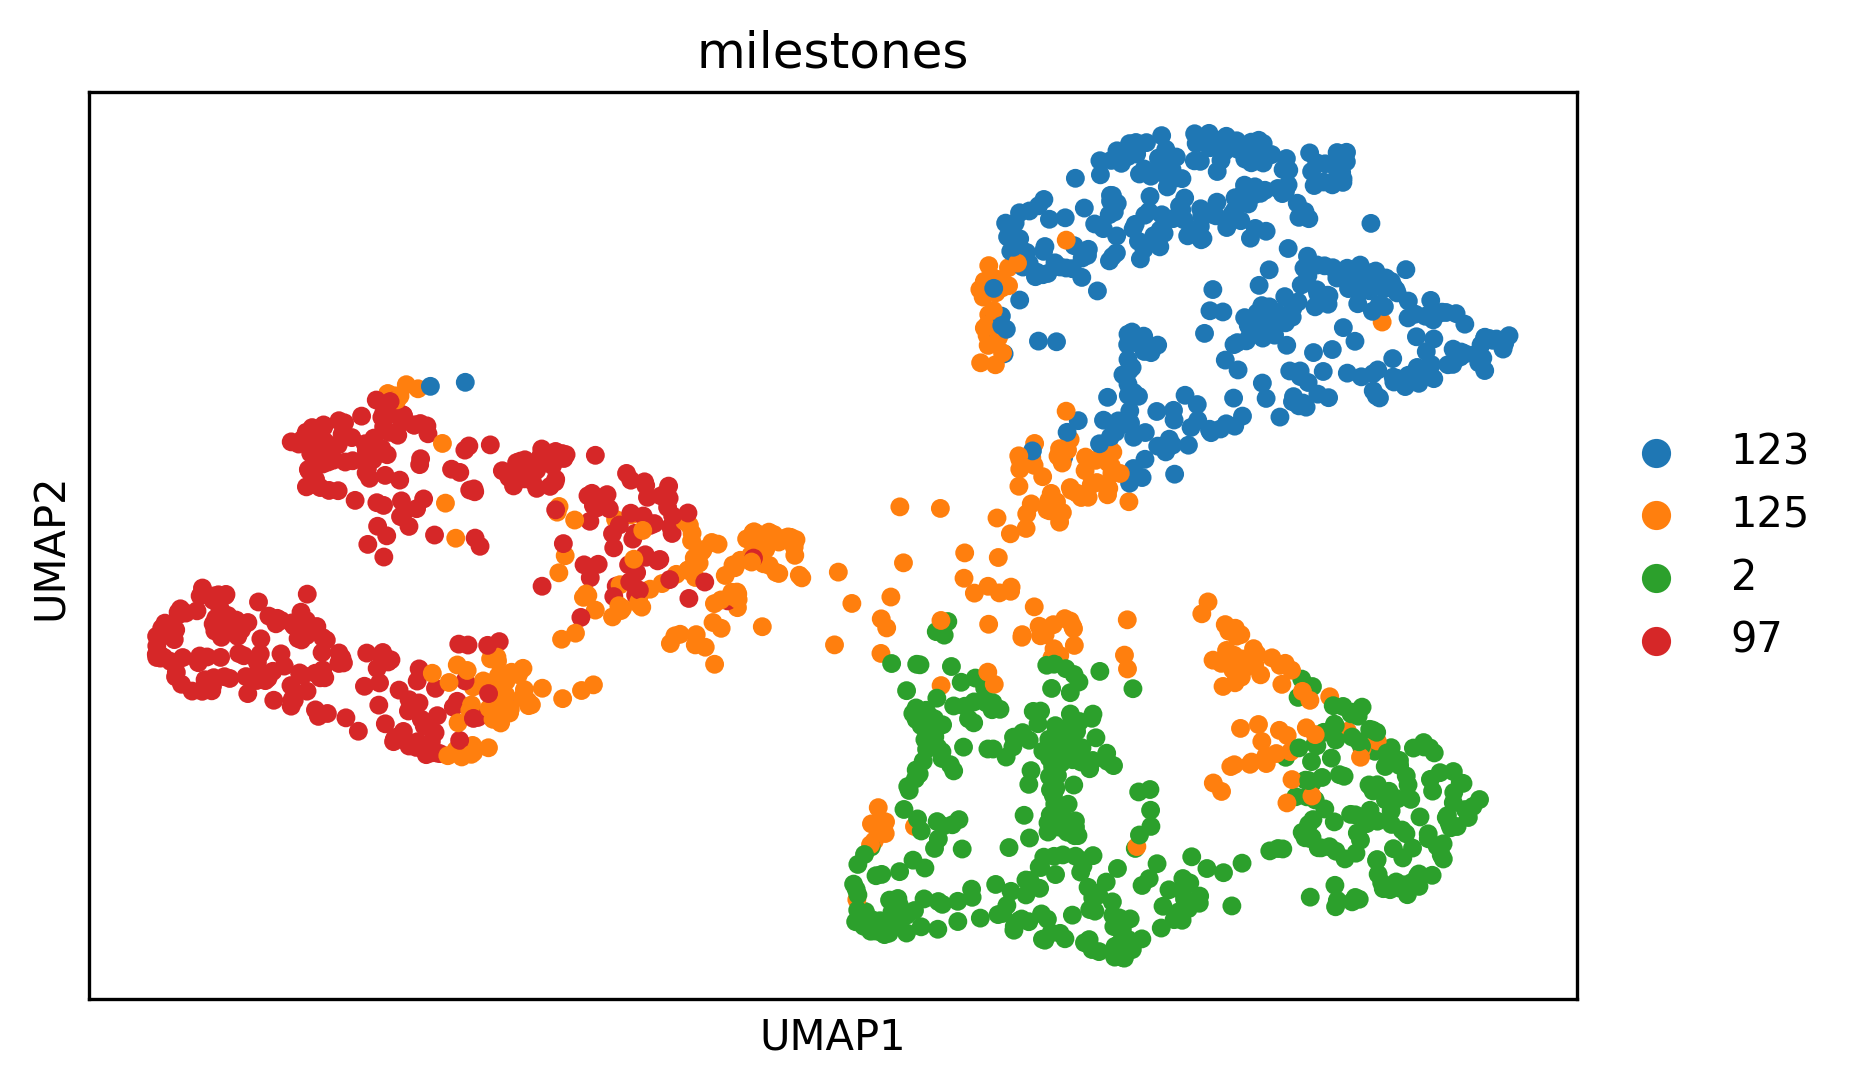

In [62]:
sc.pl.umap(adTree,color="milestones")

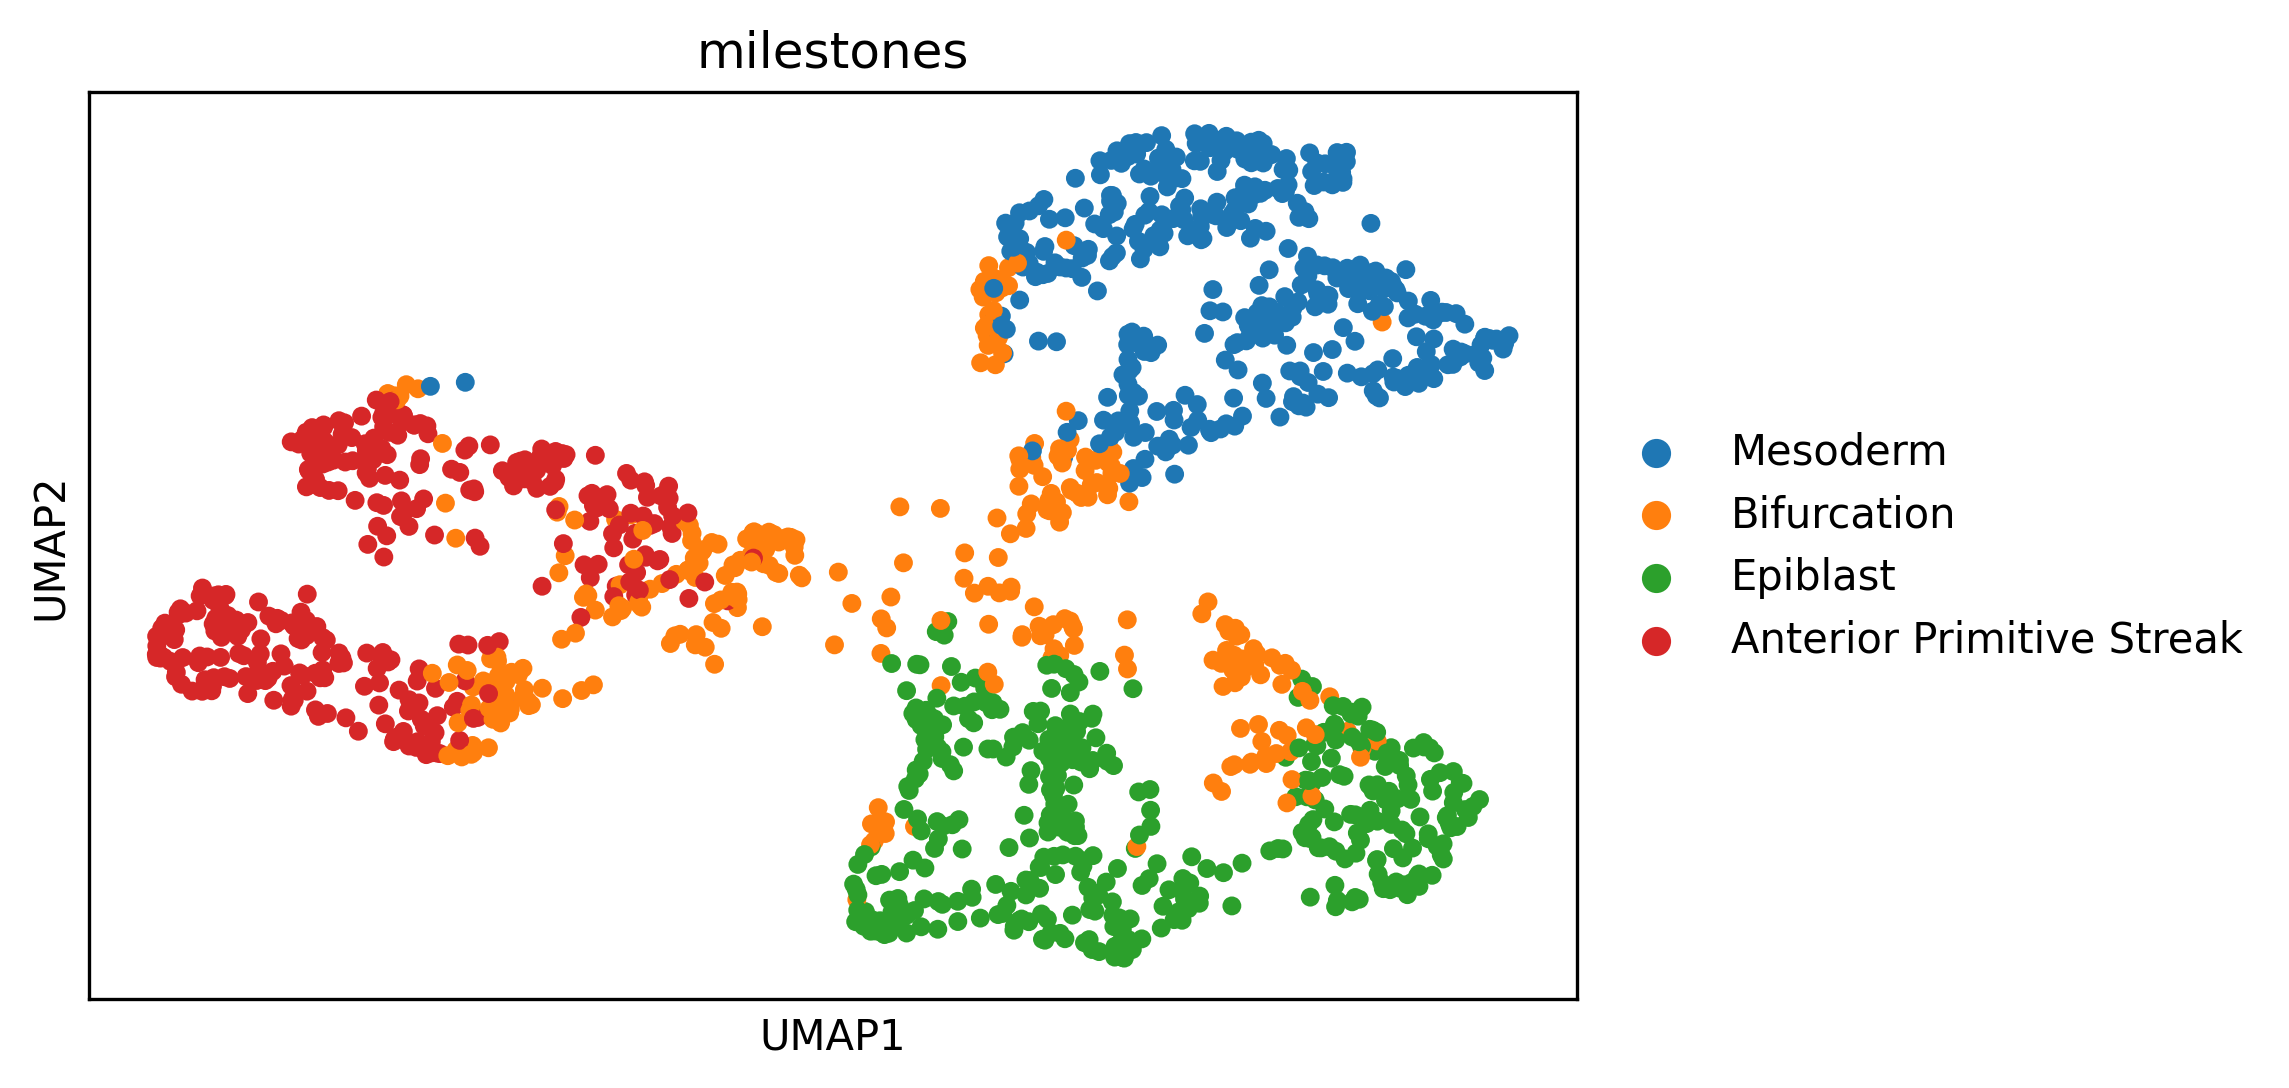

In [63]:
scf.tl.rename_milestones(adTree, {"2":"Epiblast", "125":"Bifurcation", "97":"Anterior Primitive Streak", "123":"Mesoderm"})
sc.pl.umap(adTree,color="milestones")

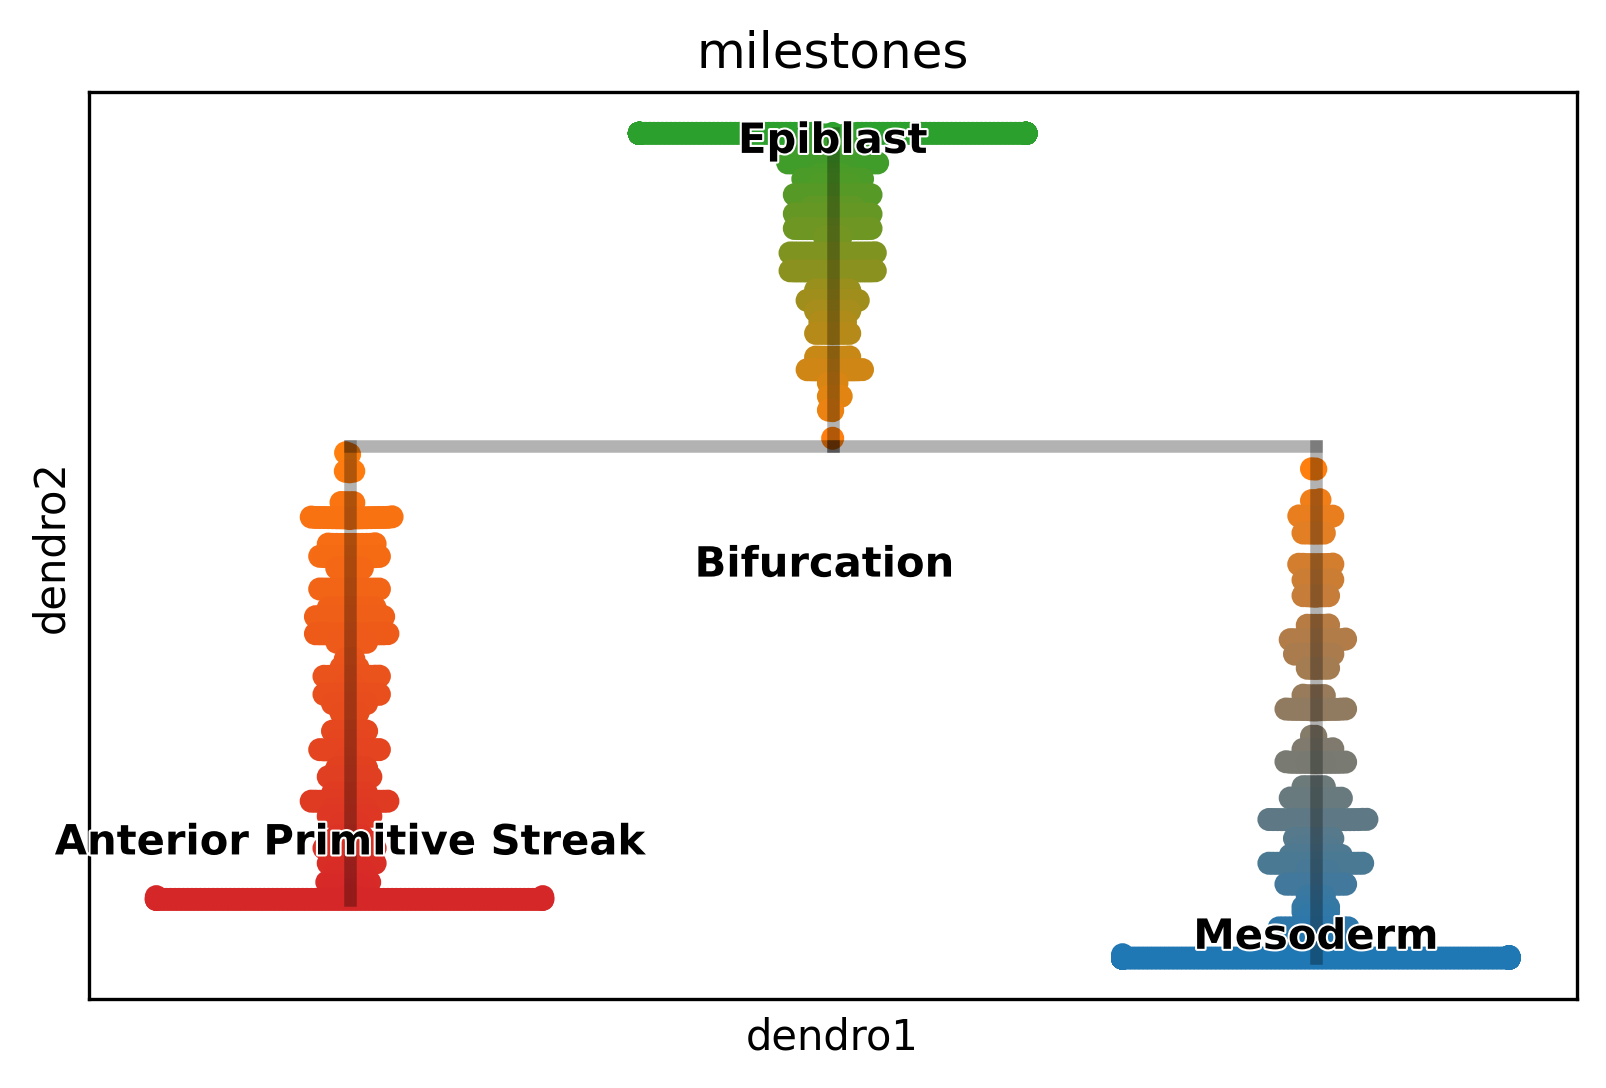

In [64]:
scf.pl.dendrogram(adTree,color="milestones",legend_loc="on data",color_milestones=True,legend_fontoutline=True)

# Part II

In [66]:
adata2 = adTree.copy()
adata2 = adata2[:, adata2.var.highly_variable]
scf.tl.test_association(adata2, reapply_filters=True)
scf.tl.fit(adata2)
scf.tl.cluster(adata2)  

test features for association with the trajectory
    single mapping : 100%|██████████| 2841/2841 [02:19<00:00, 20.33it/s]
    found 52 significant features (0:02:19) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.
fit features associated with the trajectory
    single mapping : 100%|██████████| 52/52 [00:06<00:00,  8.54it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:06) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.
Clustering features using fitted layer
    finished (0:00:00) --> added 
    .var['clusters'] identified modules.


In [67]:
scf.tl.test_fork(adata2, root_milestone="Epiblast", milestones=["Mesoderm", "Anterior Primitive Streak"], rescale=True)

testing fork
    single mapping
    Differential expression: 100%|██████████| 52/52 [00:03<00:00, 14.01it/s]
    test for upregulation for each leave vs root
    upreg Anterior Primitive Streak: 100%|██████████| 34/34 [00:00<00:00, 405.81it/s]
    finished (0:00:03) --> added 
    .uns['Epiblast->Mesoderm<>Anterior Primitive Streak']['fork'], DataFrame with fork test results.


In [68]:
scf.tl.branch_specific(adata2, root_milestone="Epiblast", milestones=["Mesoderm", "Anterior Primitive Streak"], effect = 0.5)

    branch specific features: Anterior Primitive Streak: 16, Mesoderm: 8
    finished --> updated 
    .uns['Epiblast->Mesoderm<>Anterior Primitive Streak']['fork'], DataFrame updated with additionnal 'branch' column.


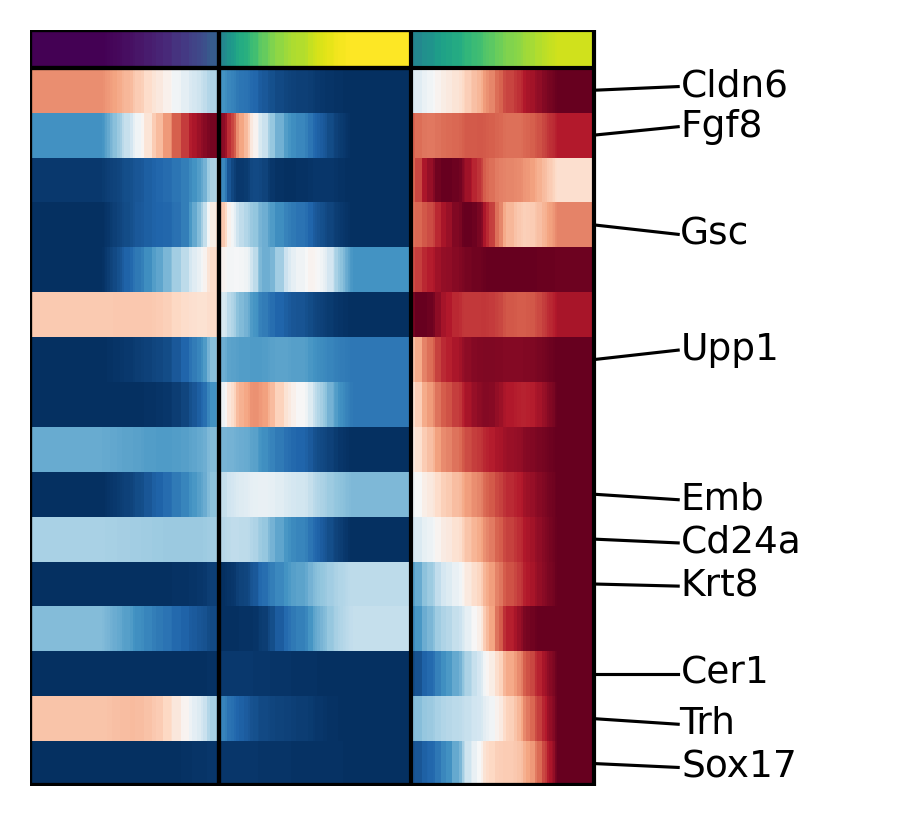

In [69]:
aps = scf.pl.trends(adata2, root_milestone="Epiblast", milestones=["Mesoderm", "Anterior Primitive Streak"], branch = 'Anterior Primitive Streak', plot_emb = False, ordering = "max", return_genes = True)

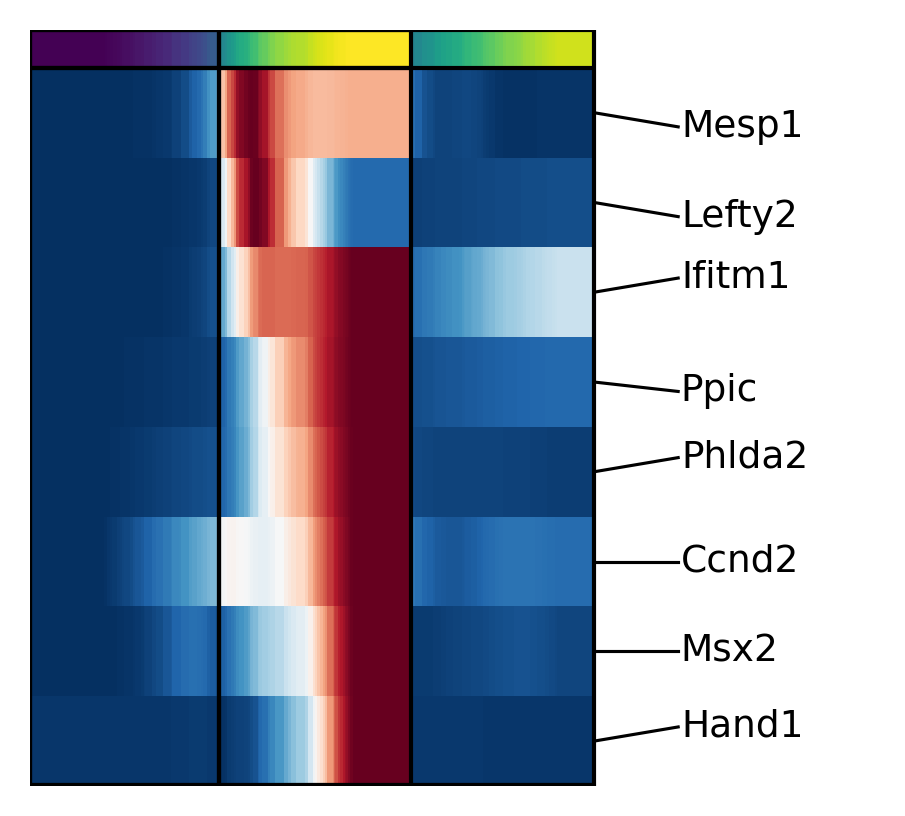

In [70]:
meso = scf.pl.trends(adata2, root_milestone="Epiblast", milestones=["Mesoderm", "Anterior Primitive Streak"], branch = 'Mesoderm', plot_emb = False, ordering = "max", return_genes = True)

In [75]:
df = adata2.uns["Epiblast->Mesoderm<>Anterior Primitive Streak"]['fork']
apsDF = df[df['branch'] == 'Anterior Primitive Streak']
mesoDF = df[df['branch'] == 'Mesoderm']

In [78]:
mouse_tf = pd.read_csv('allTFs_mm_aertslab_011924.csv', header=None, usecols=[0])
tf_inter = list(set(mouse_tf[0]).intersection(set(adata2.var_names)))
tf_inter

['Mixl1',
 'Sox17',
 'Rbms1',
 'Id1',
 'Lhx1',
 'Phlda2',
 'Mesp1',
 'Foxa2',
 'Msx2',
 'Sp5',
 'Pou5f1',
 'T',
 'Gsc',
 'Mycn',
 'Hand1']

In [79]:
apsDFTFs = apsDF[apsDF.index.isin(tf_inter)]
mesoDFTFs = mesoDF[mesoDF.index.isin(tf_inter)]

In [80]:
apsDFTFs

Anterior Primitive Streak  Mesoderm           de_p            fdr  \
Sox17                        0.0 -1.218163  6.318155e-171  3.285440e-169   
Foxa2                        0.0 -0.808365  4.791641e-136  2.491653e-134   
Lhx1                         0.0 -0.586085   3.841951e-40   1.997814e-38   
Gsc                          0.0 -0.694856   2.201286e-68   1.144669e-66   

       signi_p  signi_fdr      up_A           up_p                     branch  
Sox17      1.0        1.0  0.177358  3.046765e-164  Anterior Primitive Streak  
Foxa2      1.0        1.0  0.080476   3.790816e-79  Anterior Primitive Streak  
Lhx1       1.0        1.0  0.124478  1.786519e-147  Anterior Primitive Streak  
Gsc        1.0        1.0  0.086845   3.373940e-75  Anterior Primitive Streak

In [81]:
mesoDFTFs

Anterior Primitive Streak  Mesoderm           de_p            fdr  \
Mesp1                   -1.701505       0.0  1.116129e-206  5.803868e-205   
Phlda2                  -2.384968       0.0   0.000000e+00   0.000000e+00   
Hand1                   -0.775940       0.0   6.903867e-88   3.590011e-86   
Msx2                    -0.547957       0.0   3.732939e-75   1.941128e-73   

        signi_p  signi_fdr      up_A           up_p    branch  
Mesp1       1.0        1.0  0.167927  2.357999e-154  Mesoderm  
Phlda2      1.0        1.0  0.293415   0.000000e+00  Mesoderm  
Hand1       1.0        1.0  0.100727  2.719864e-113  Mesoderm  
Msx2        1.0        1.0  0.069415  7.418659e-109  Mesoderm

I'll use all transcription factors indicated here for GRN reconstruction.

| APS | Mesoderm |
| --- | -------- |
| Foxa2, Gsc, Lhx1, Sox17 | Mesp1, Phlda2, Hand1, Msx2| 

# Part III

In [87]:
tfs = ['Sox17', 'Foxa2', 'Lhx1', 'Gsc', 'Mesp1', 'Phlda2', 'Hand1', 'Msx2']
adGRN = adata2[:, adata2.var_names.isin(tfs)].copy()
adTrain_rank, adHeldOut_rank = pySCN.splitCommonAnnData(adGRN, ncells=50, dLevel='milestones')
clf = pySCN.train_rank_classifier(adTrain_rank, dLevel='milestones')

Mesoderm : 
397
Epiblast : 
412
Bifurcation : 
322
Anterior Primitive Streak : 
333


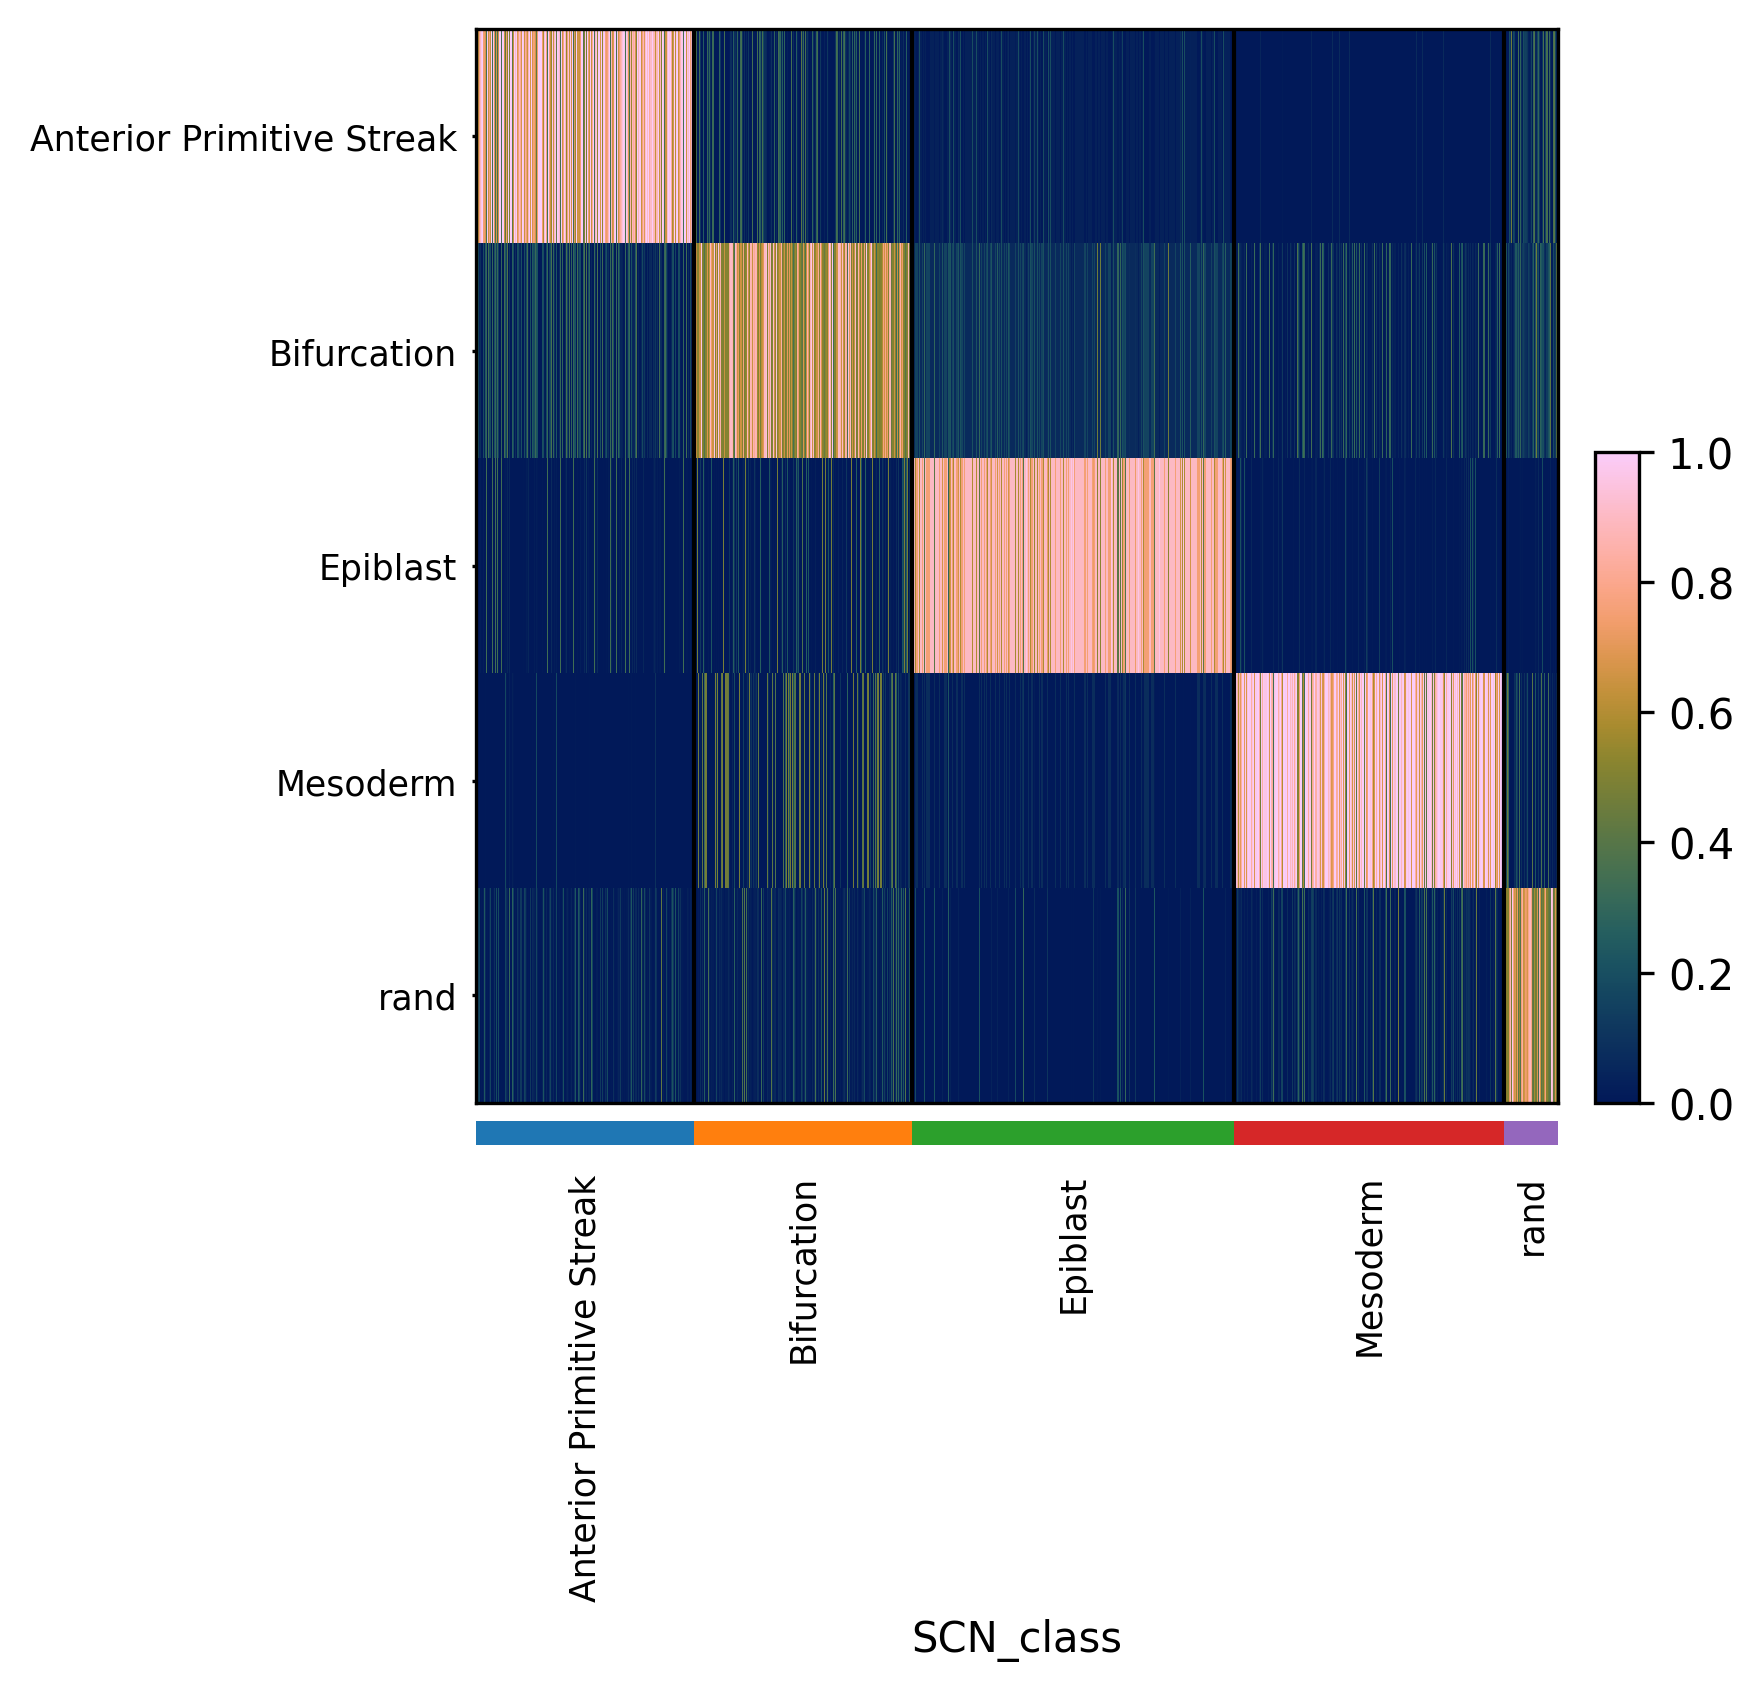

In [88]:
pySCN.rank_classify(adHeldOut_rank, clf)
pySCN.heatmap_scores(adHeldOut_rank, groupby='SCN_class')

In [89]:
initial_clusters = ['Epiblast']
end_clusters = ['Mesoderm', 'Anterior Primitive Streak']

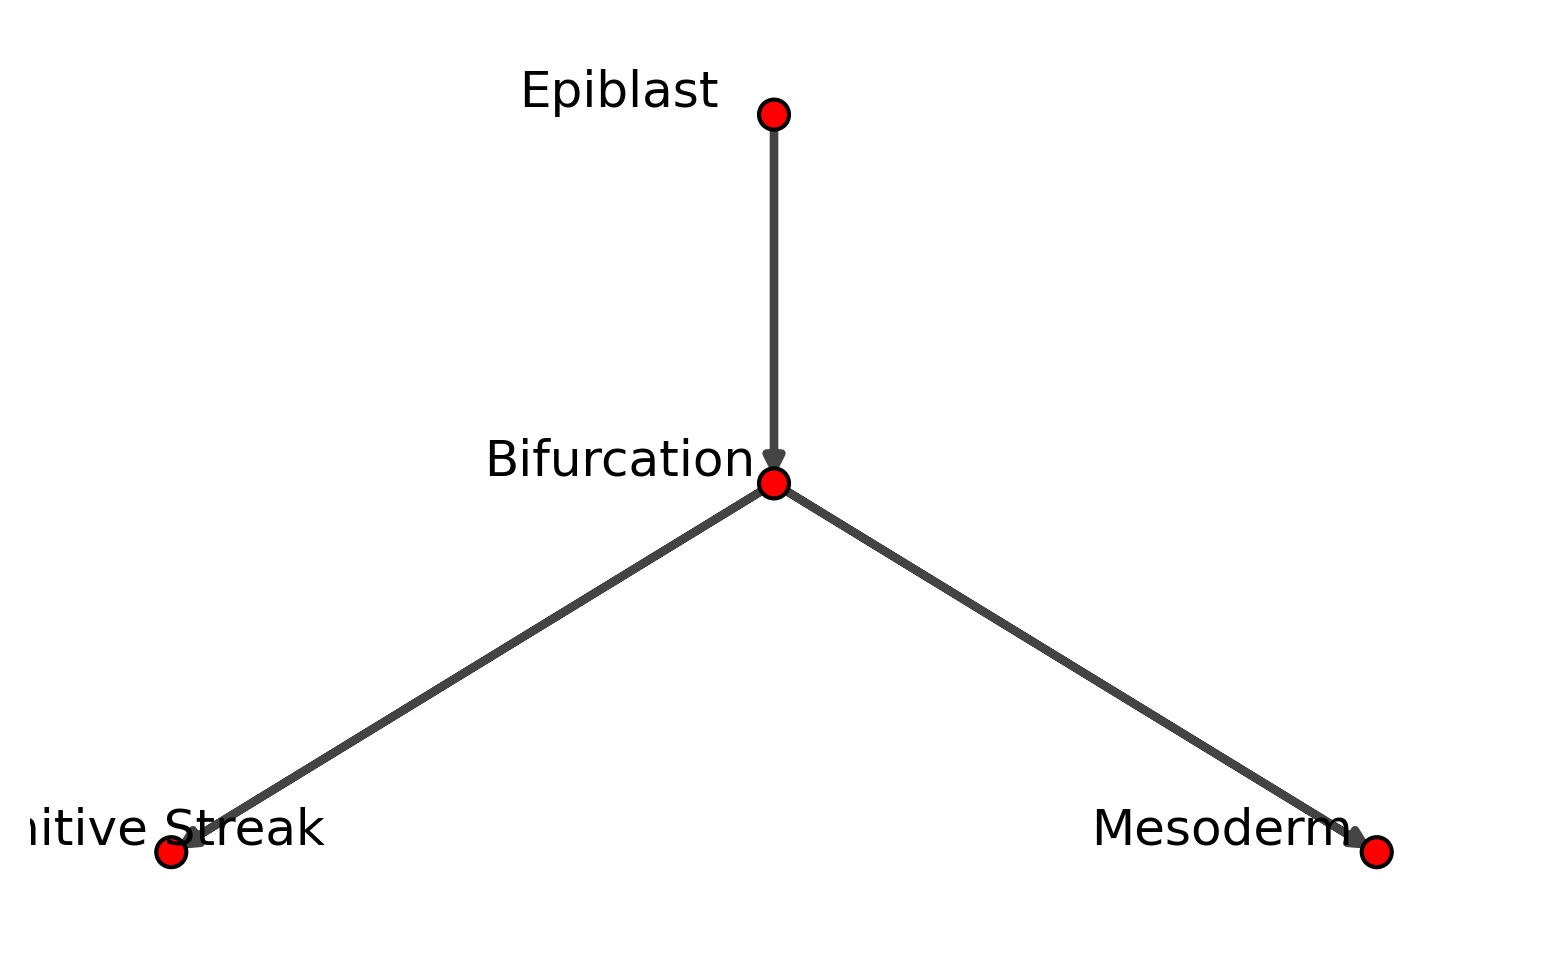

In [90]:
edge_list = [('Epiblast', 'Bifurcation'), ('Bifurcation', 'Anterior Primitive Streak'), ('Bifurcation', 'Mesoderm')]
state_path = nx.DiGraph(edge_list)
onesc.plot_state_graph(state_path)

Preparing states and data for GA ...
Starting network reconstruction with GA ...
GRN reconstruction complete.


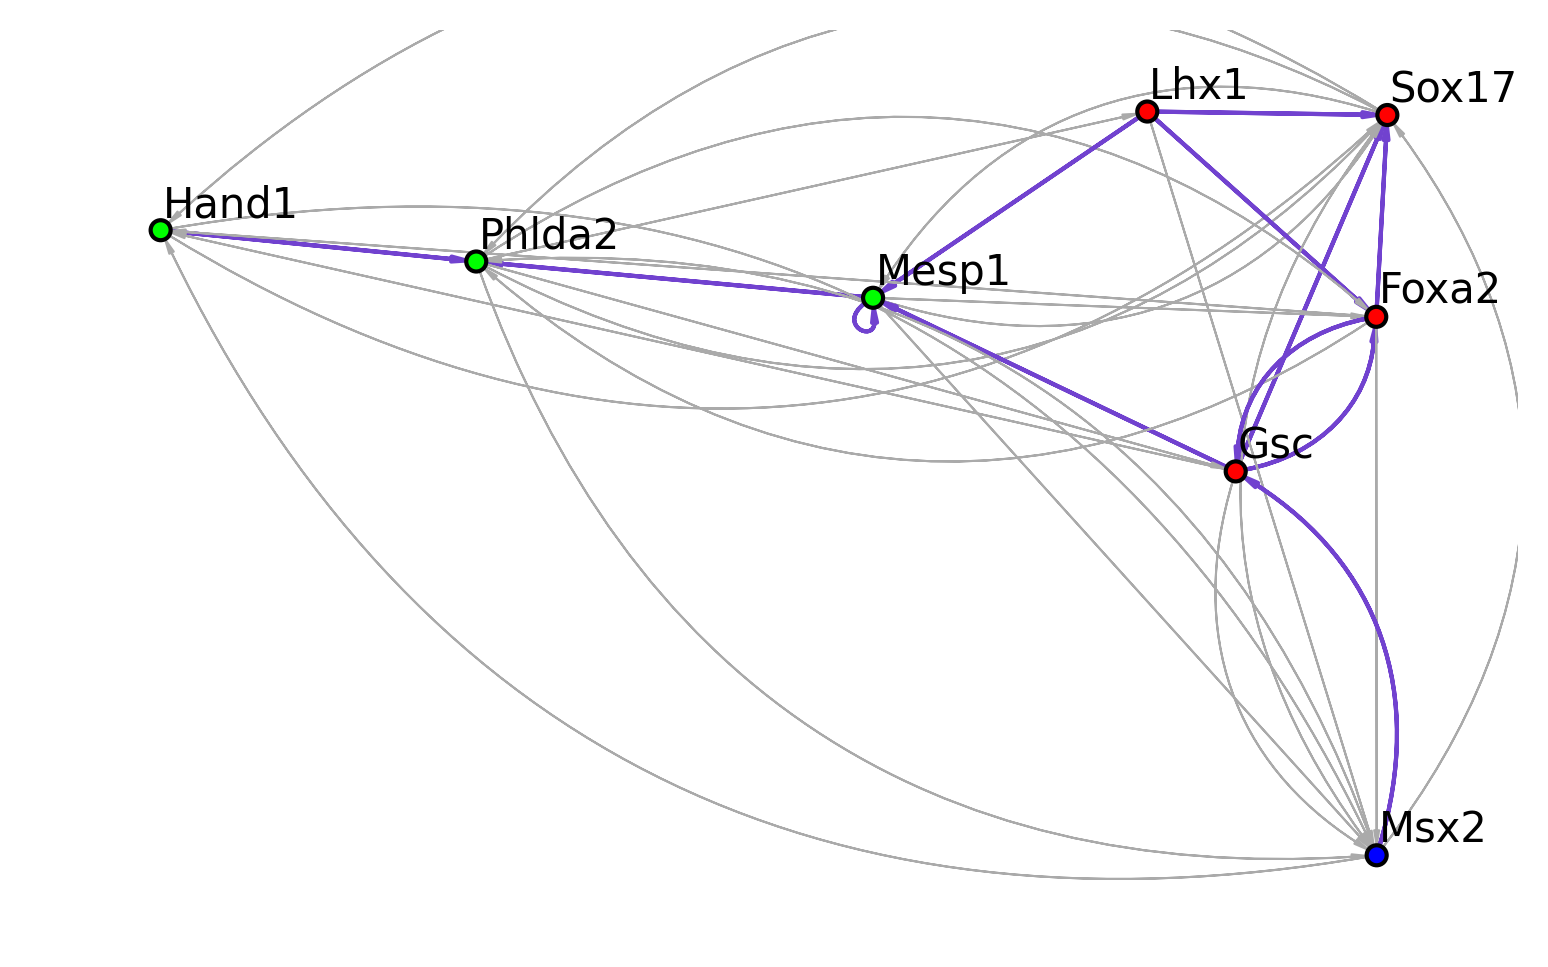

In [91]:
start_end_states = {'start': ['Epiblast'], 'end':['Mesoderm', 'Anterior Primitive Streak']}

iGRN = onesc.infer_grn(state_path, start_end_states, adGRN, num_generations = 20, sol_per_pop = 30, reduce_auto_reg=True, ideal_edges = 0, GA_seed_list = [1, 3], init_pop_seed_list = [21, 25], cluster_col='milestones', pseudoTime_col='t')

grn_ig = onesc.dataframe_to_igraph(iGRN)
onesc.plot_grn(grn_ig, layout_method='fr',community_first=True)

# Part IV

In [97]:
adEpi = sc.read_h5ad("/Users/ryang/Documents/Academics/Spring 2024/CSCB/Homework/HW5/mESC_HW5.h5ad")
xstates = onesc.define_states_adata(adEpi, min_mean = 0.05, min_percent_cells = 0.20) * 2 

In [98]:
netname = 'Epidiff'
netsim = onesc.network_structure()
netsim.fit_grn(iGRN)
sim = onesc.OneSC_simulator()
sim.add_network_compilation(netname, netsim)

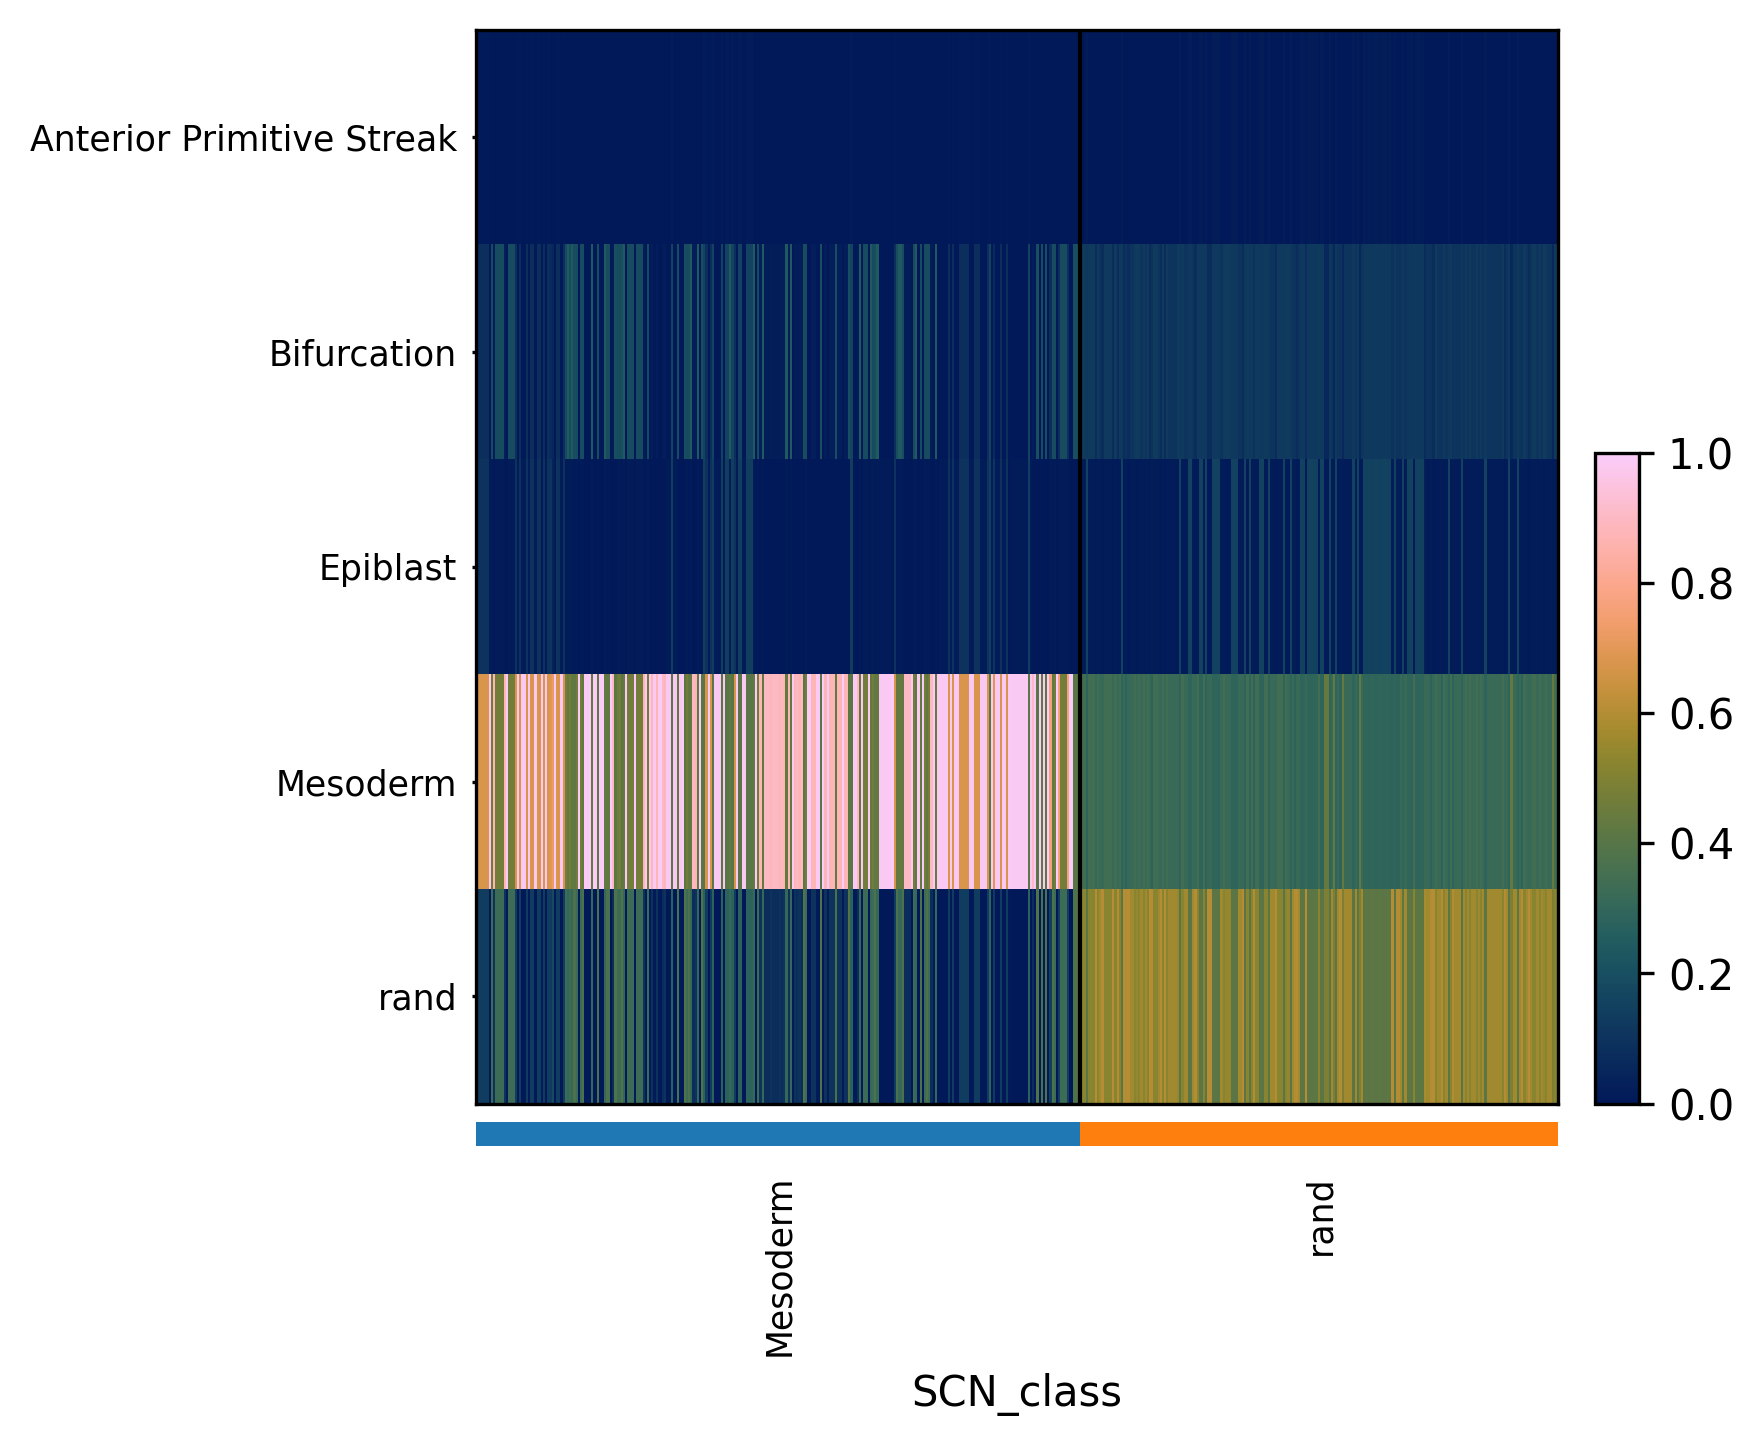

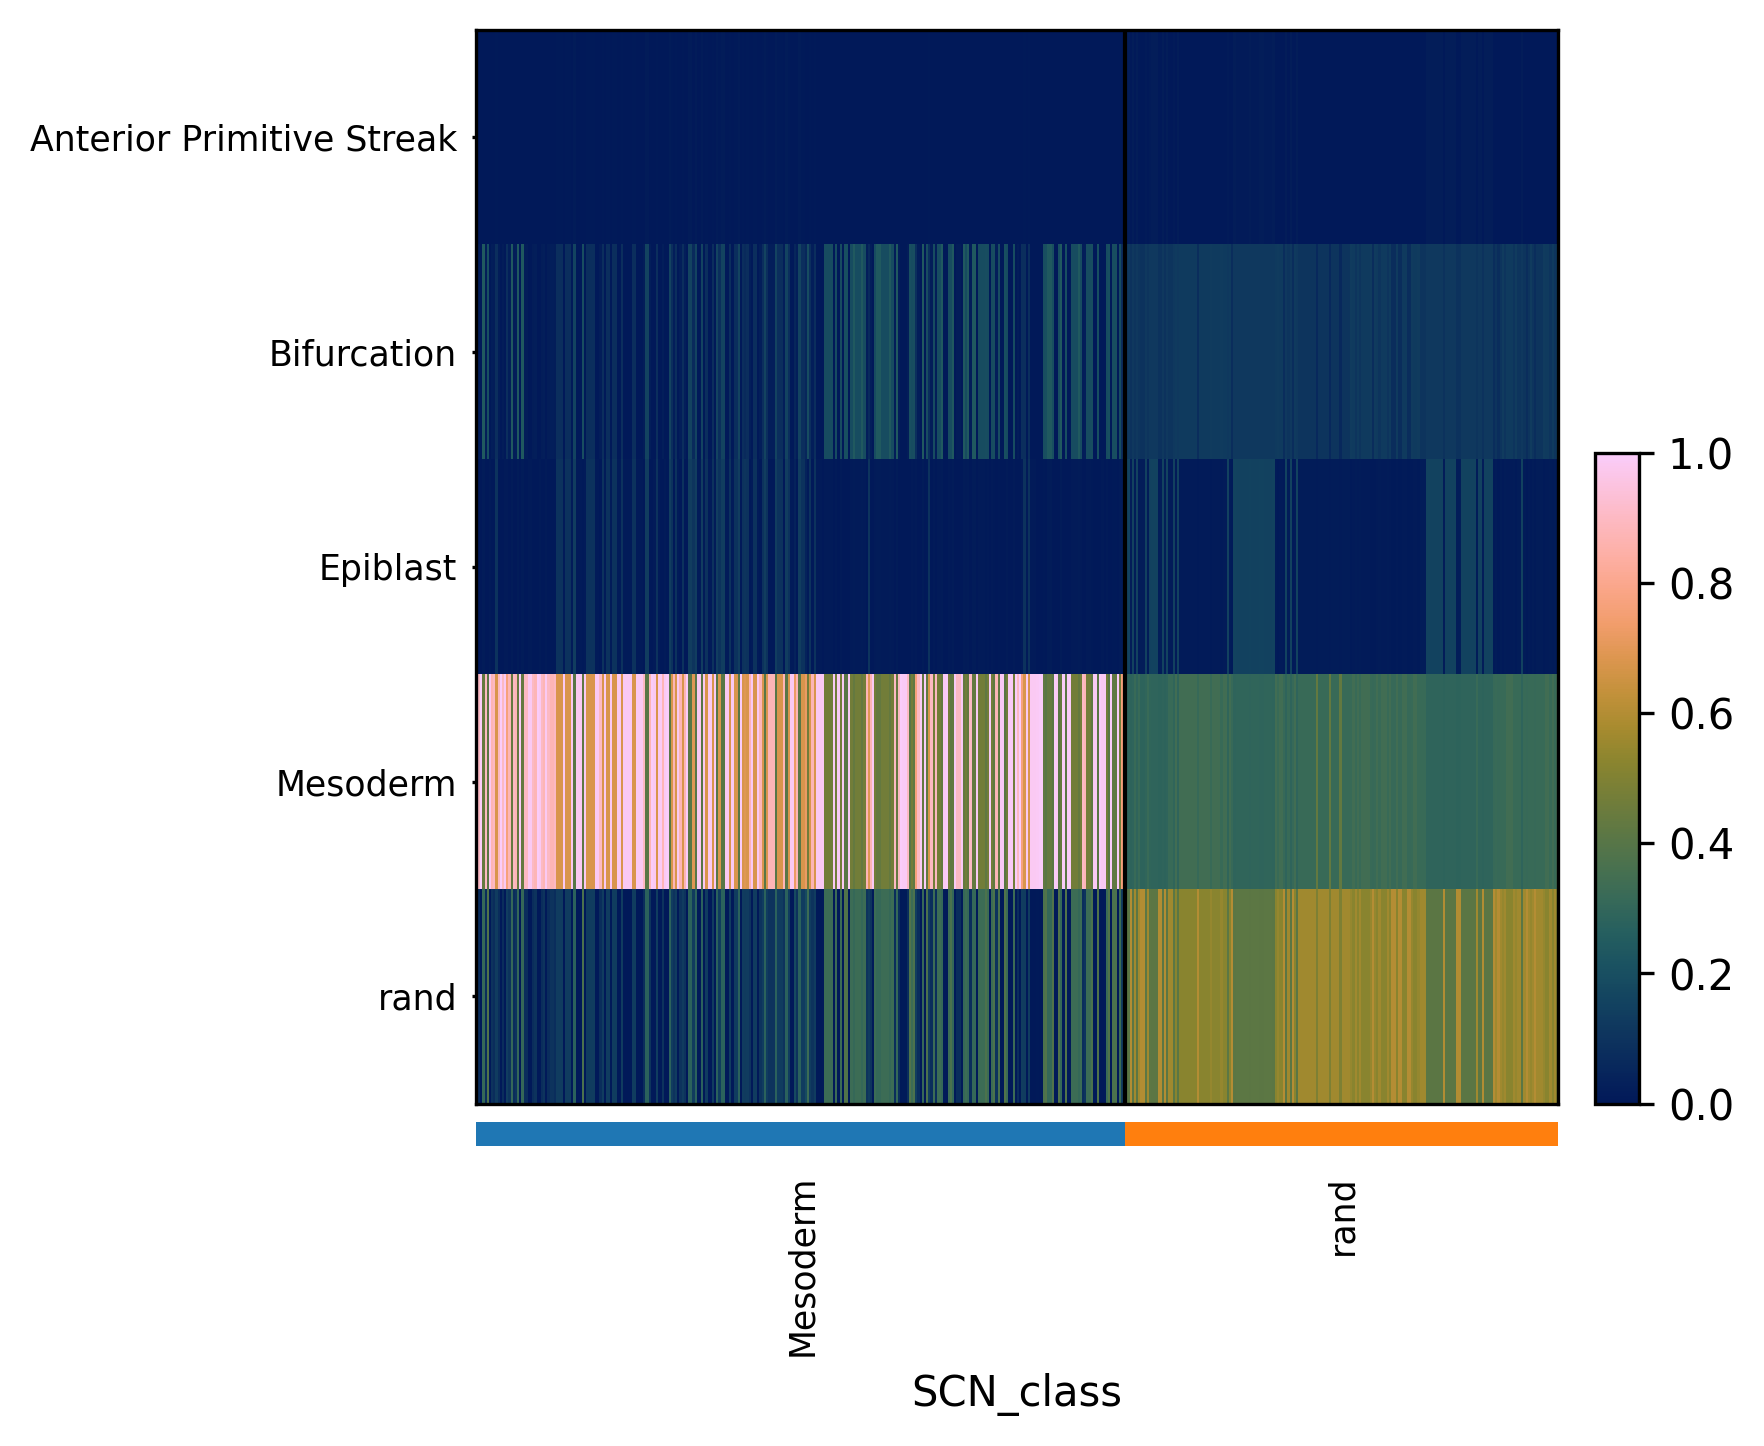

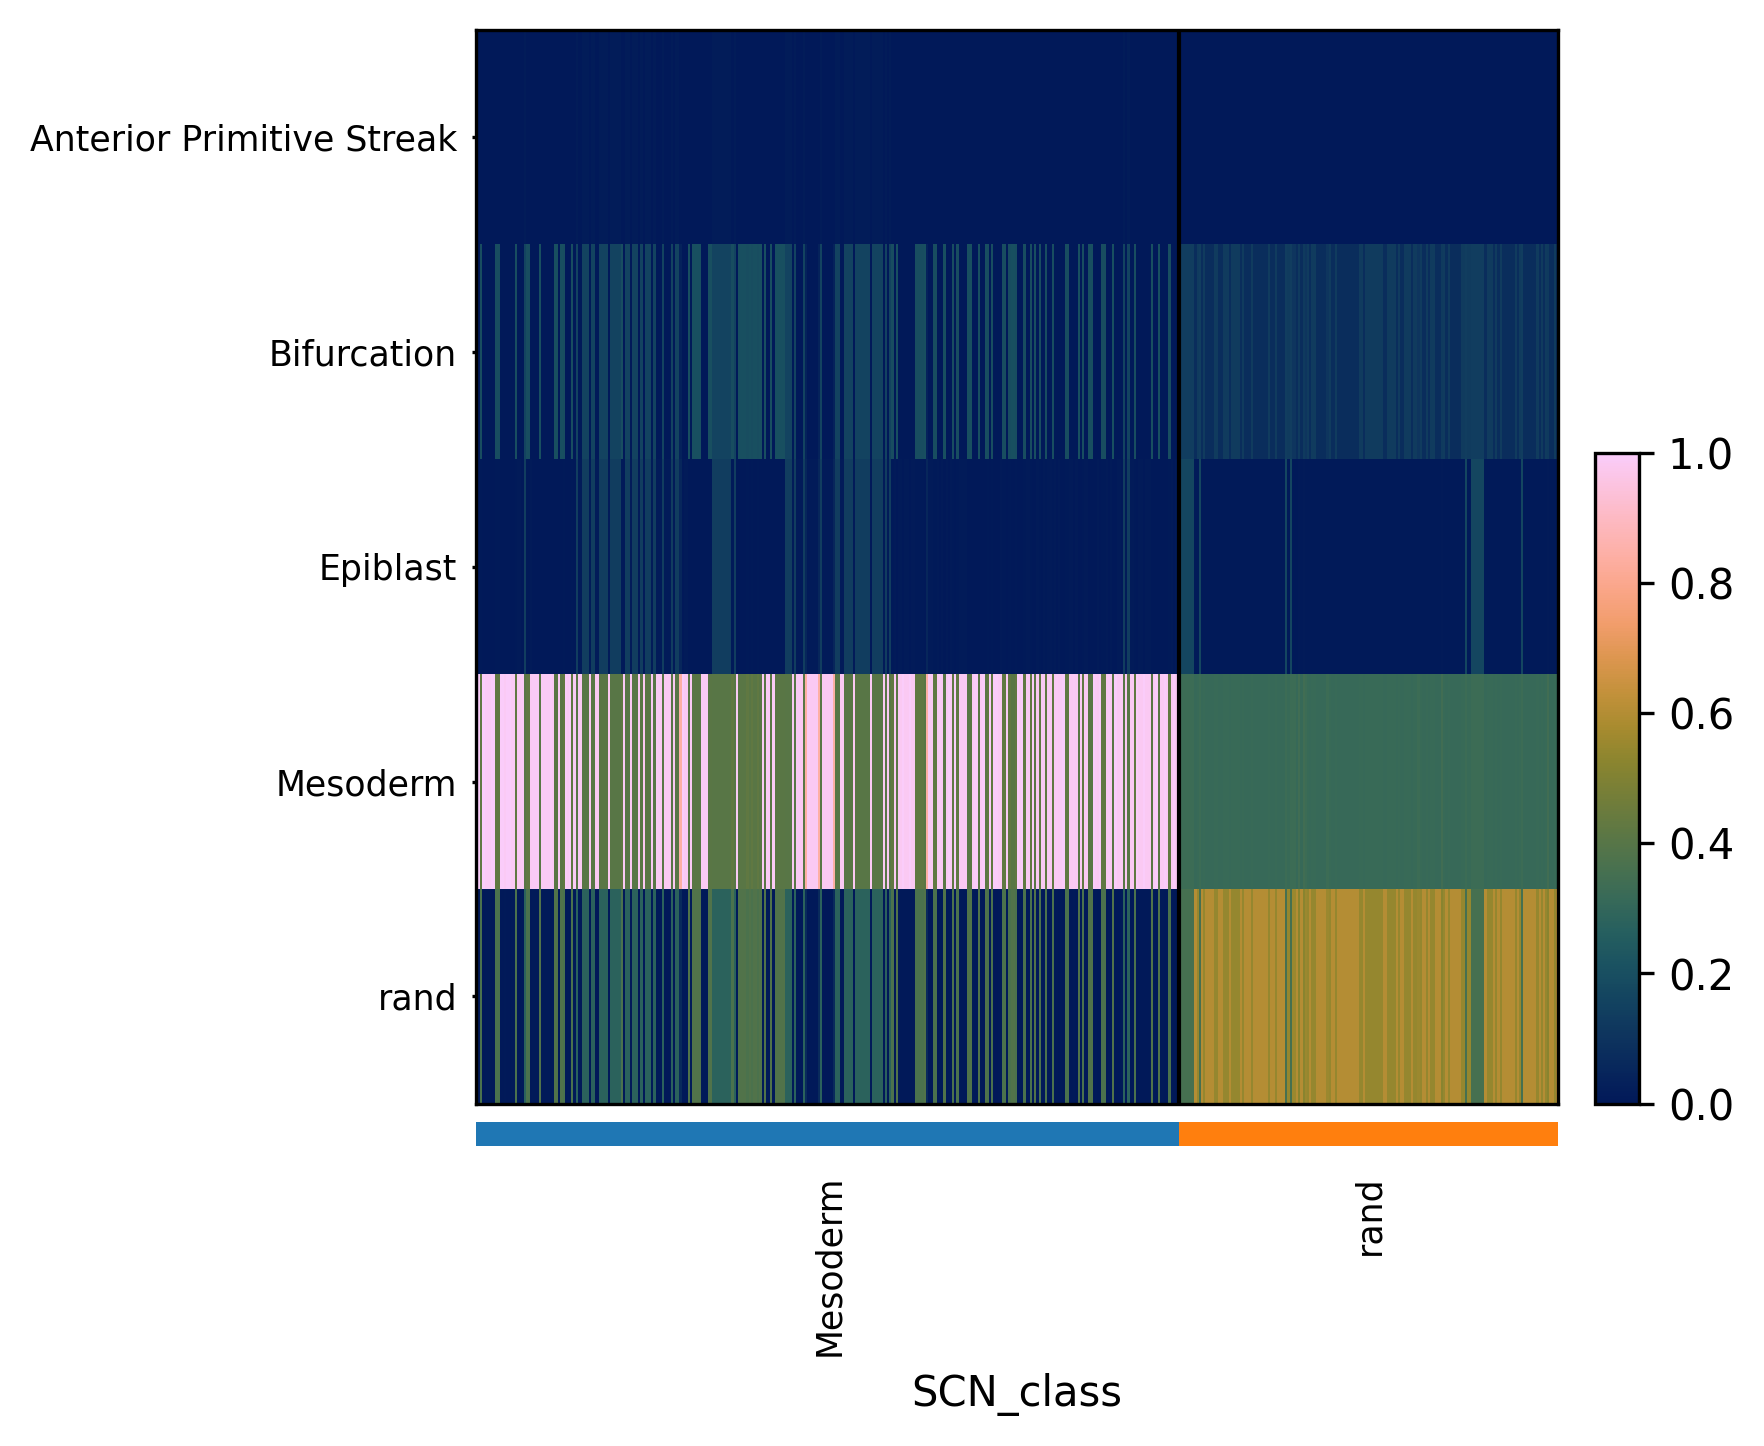

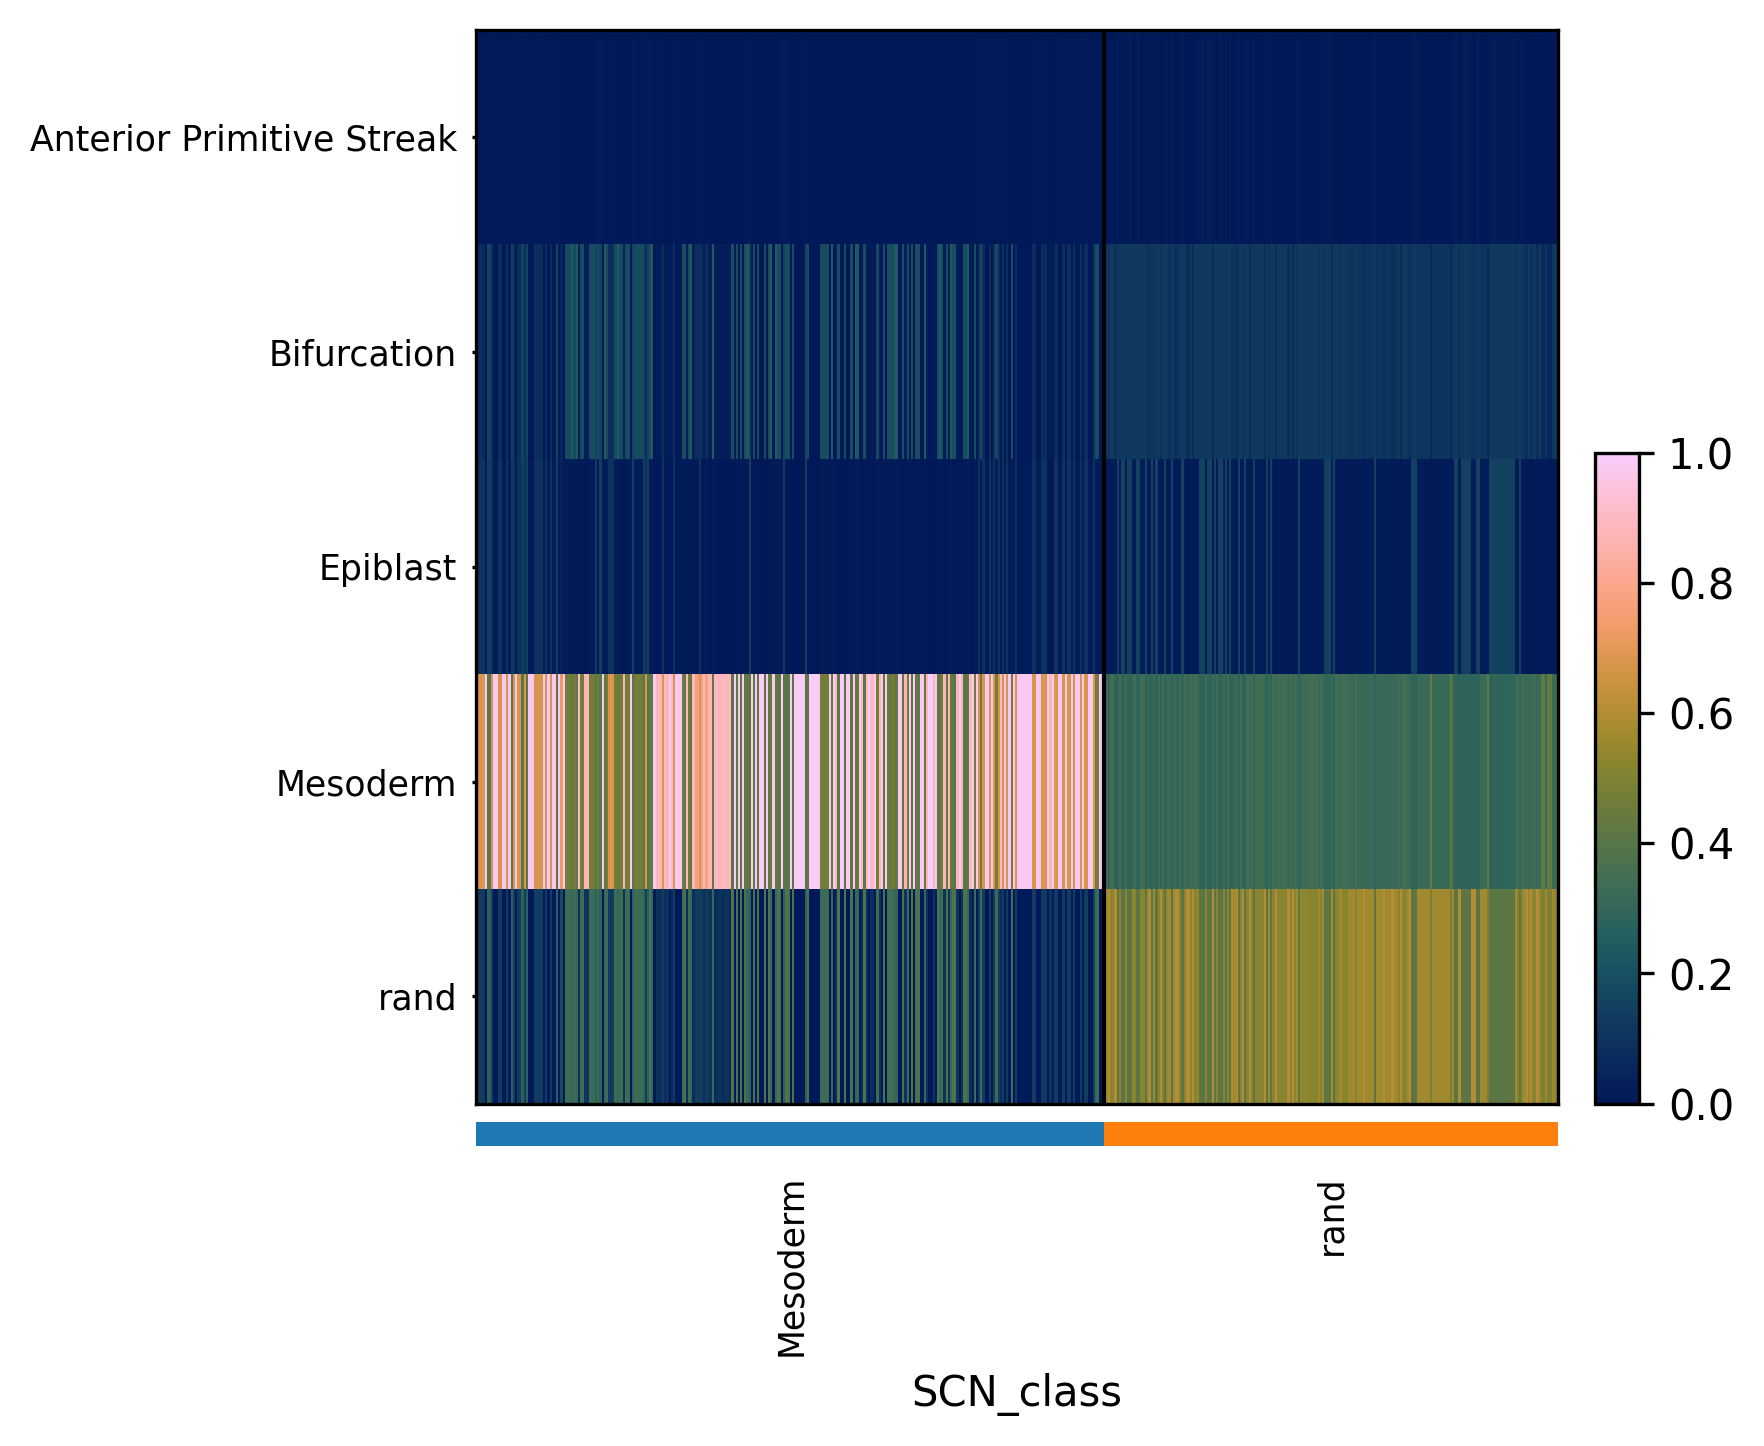

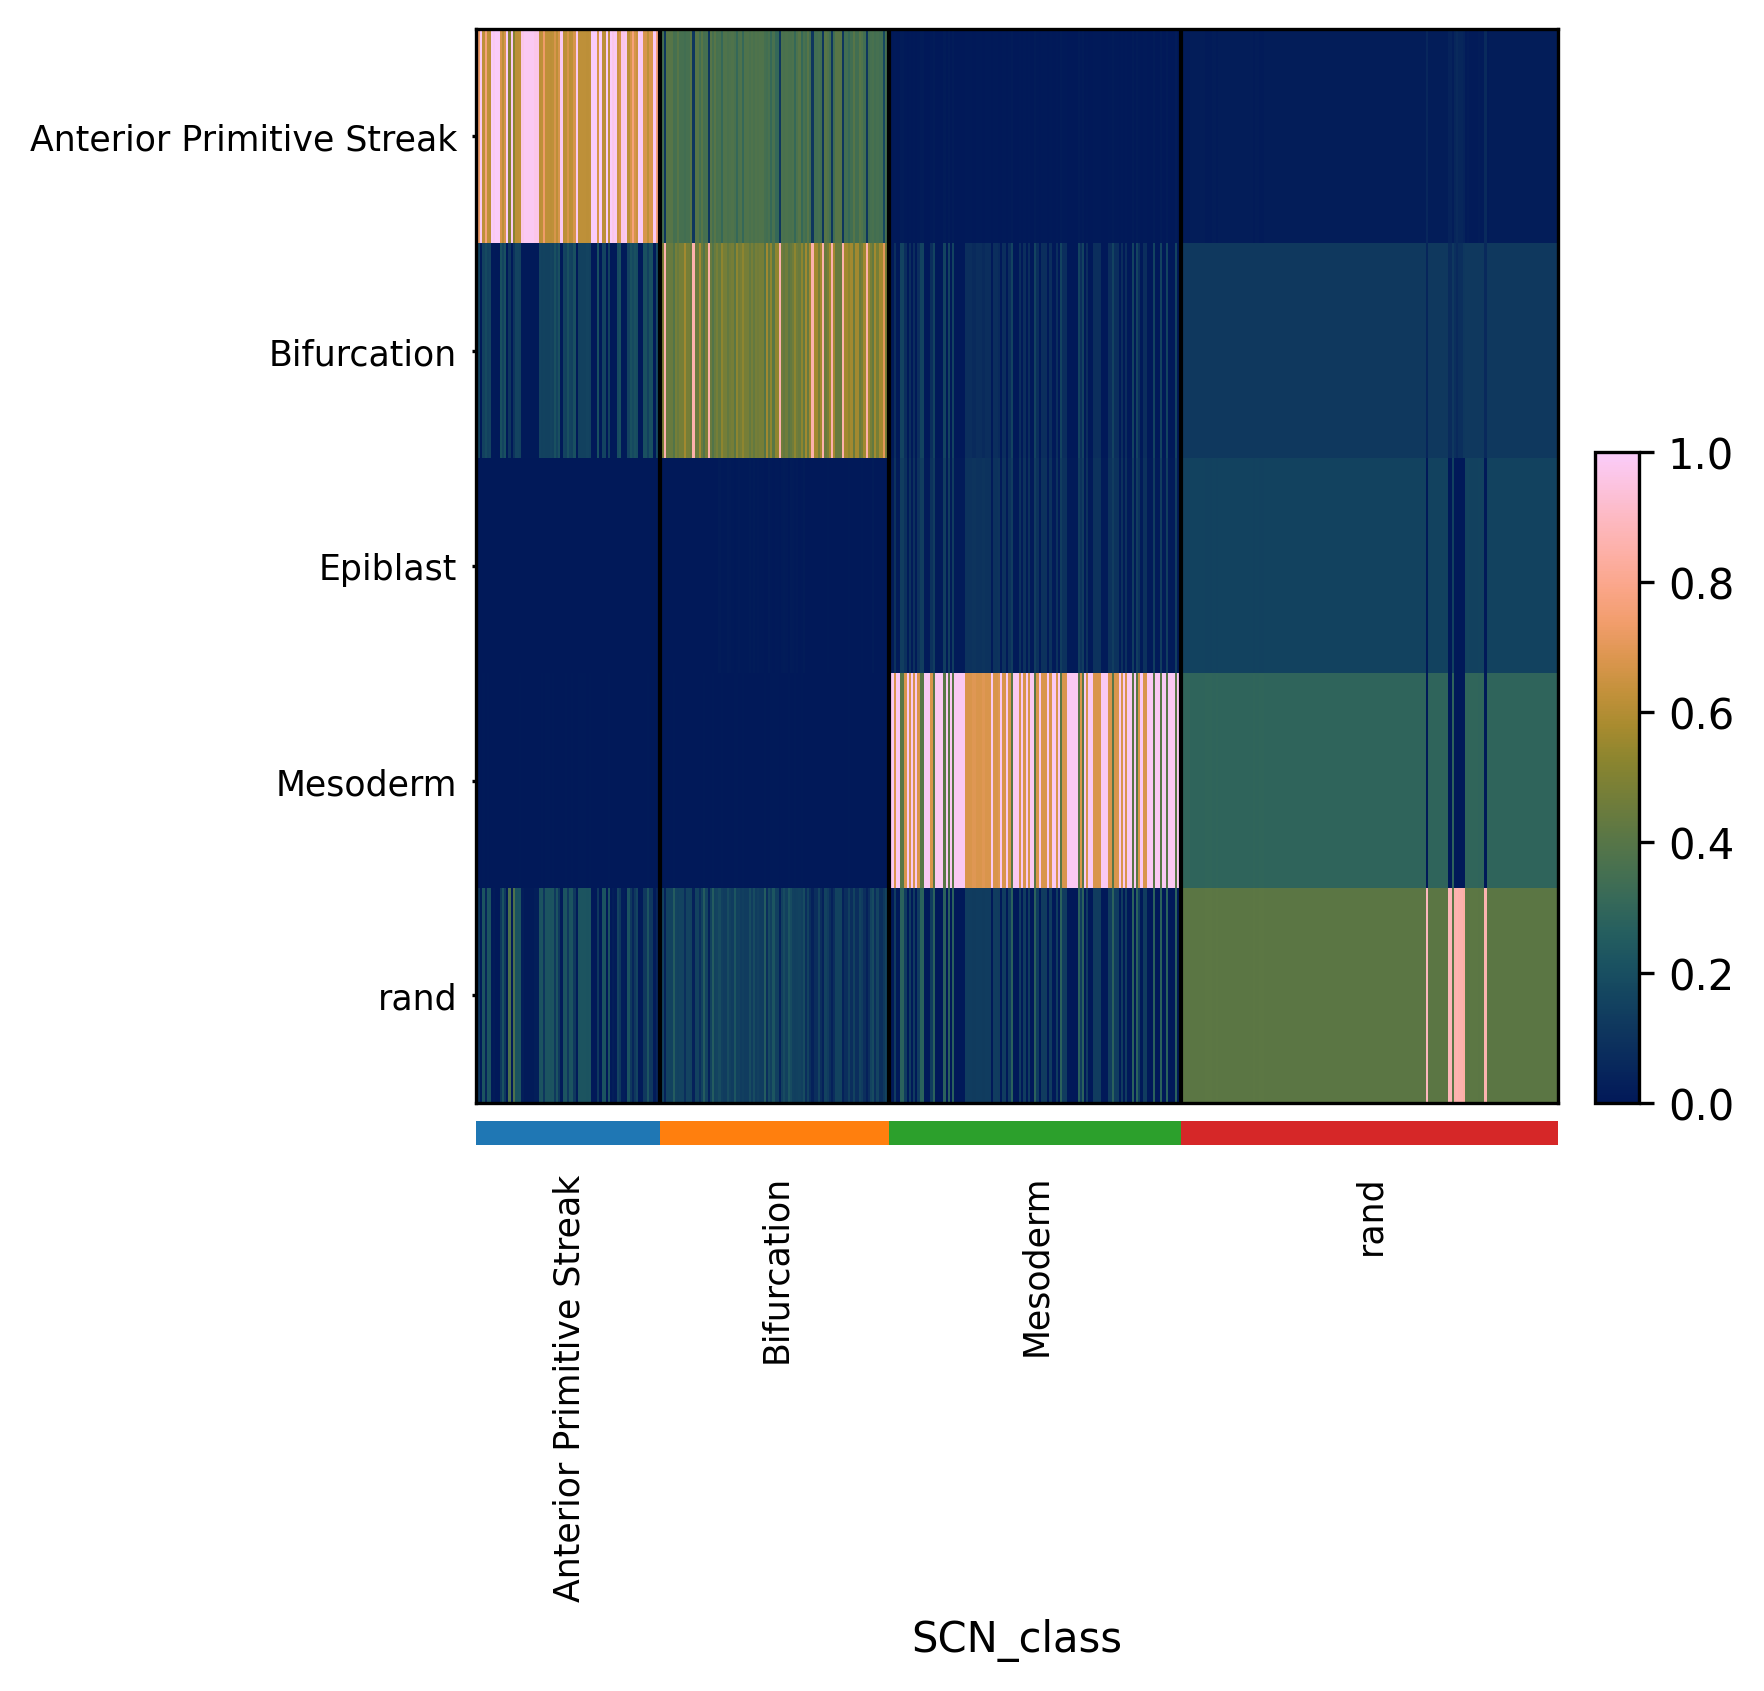

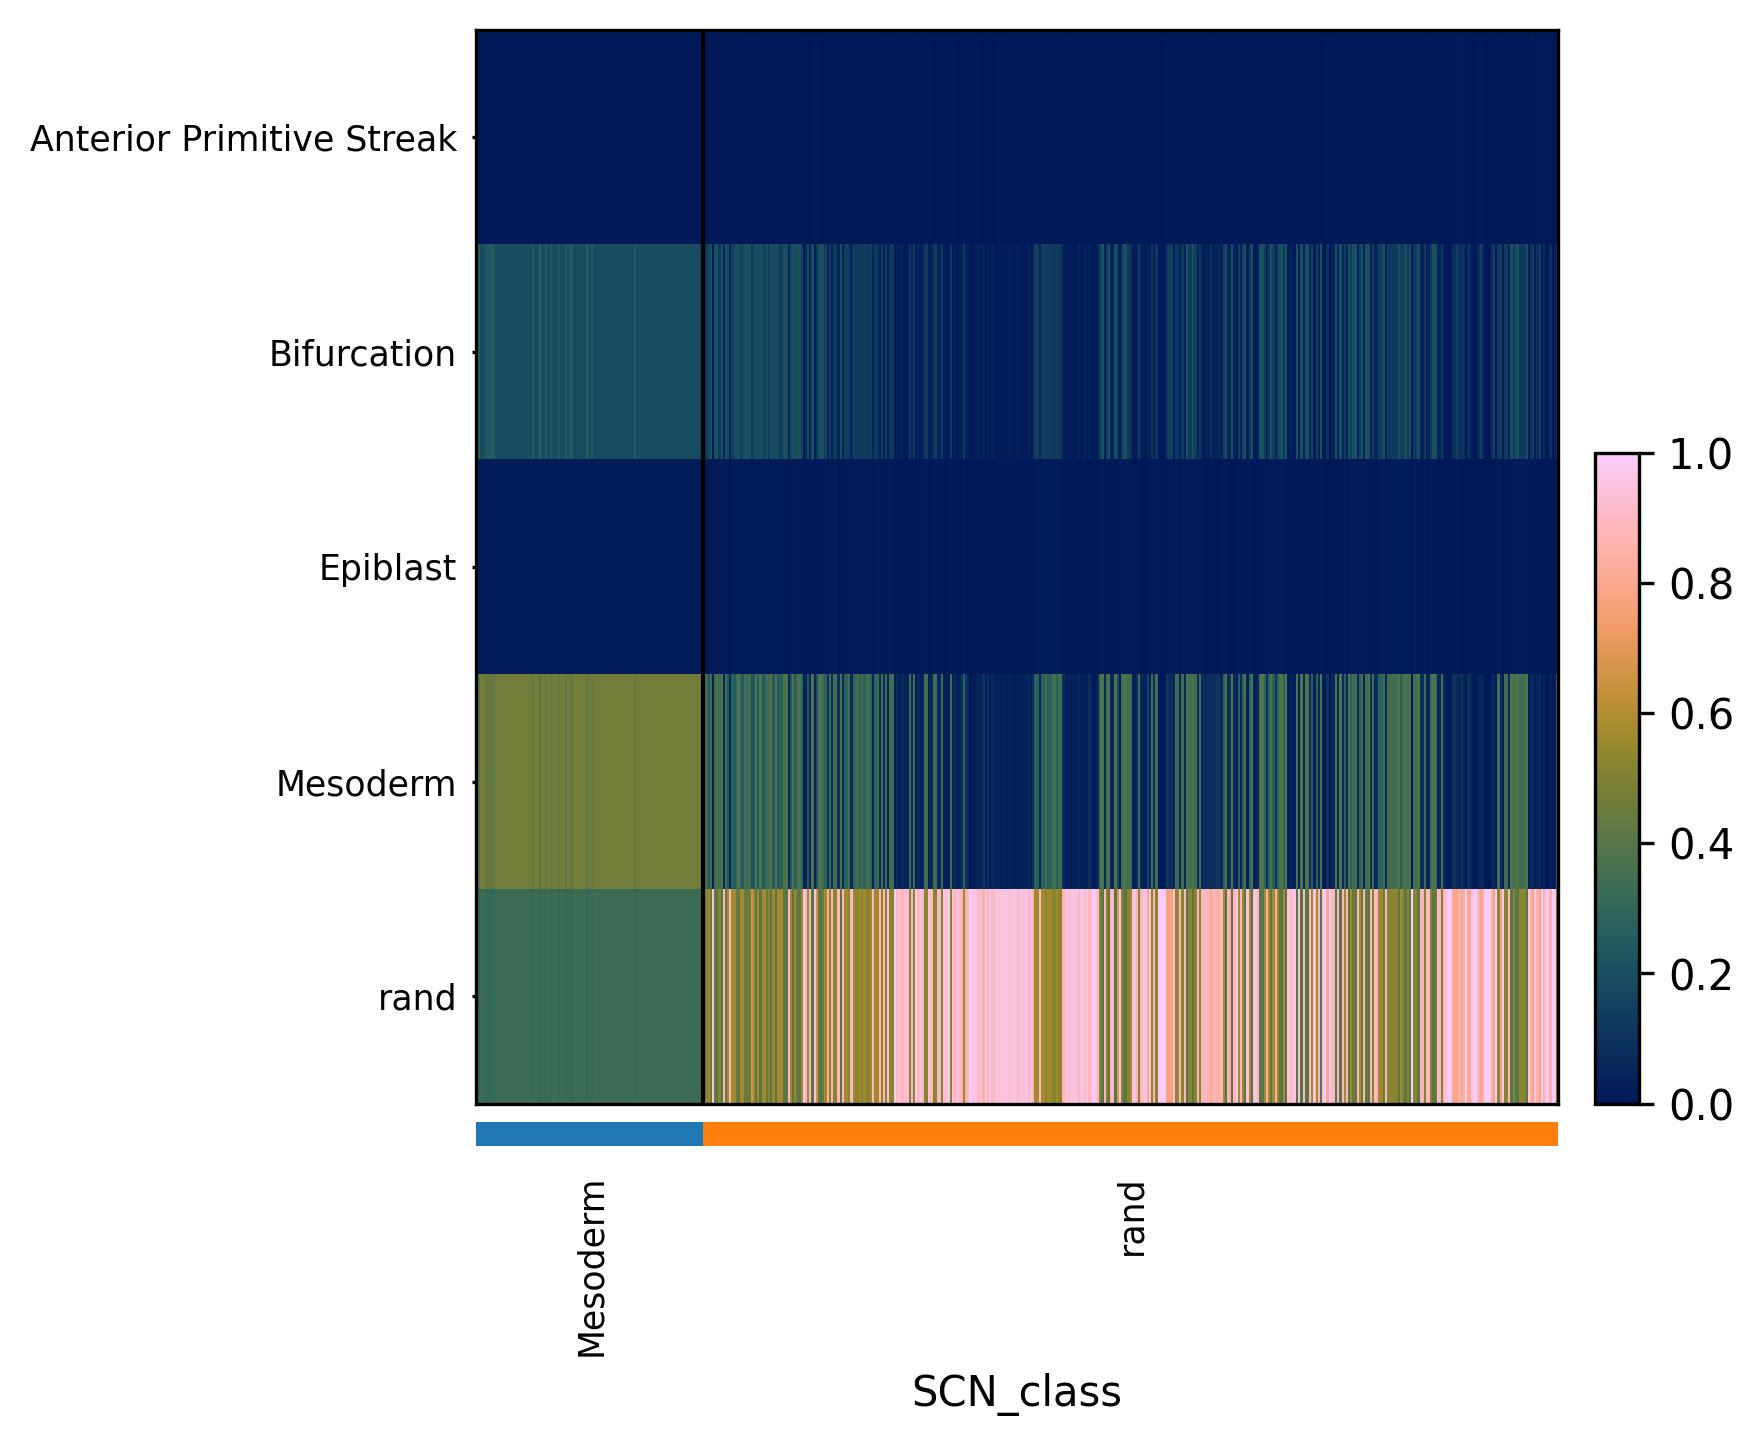

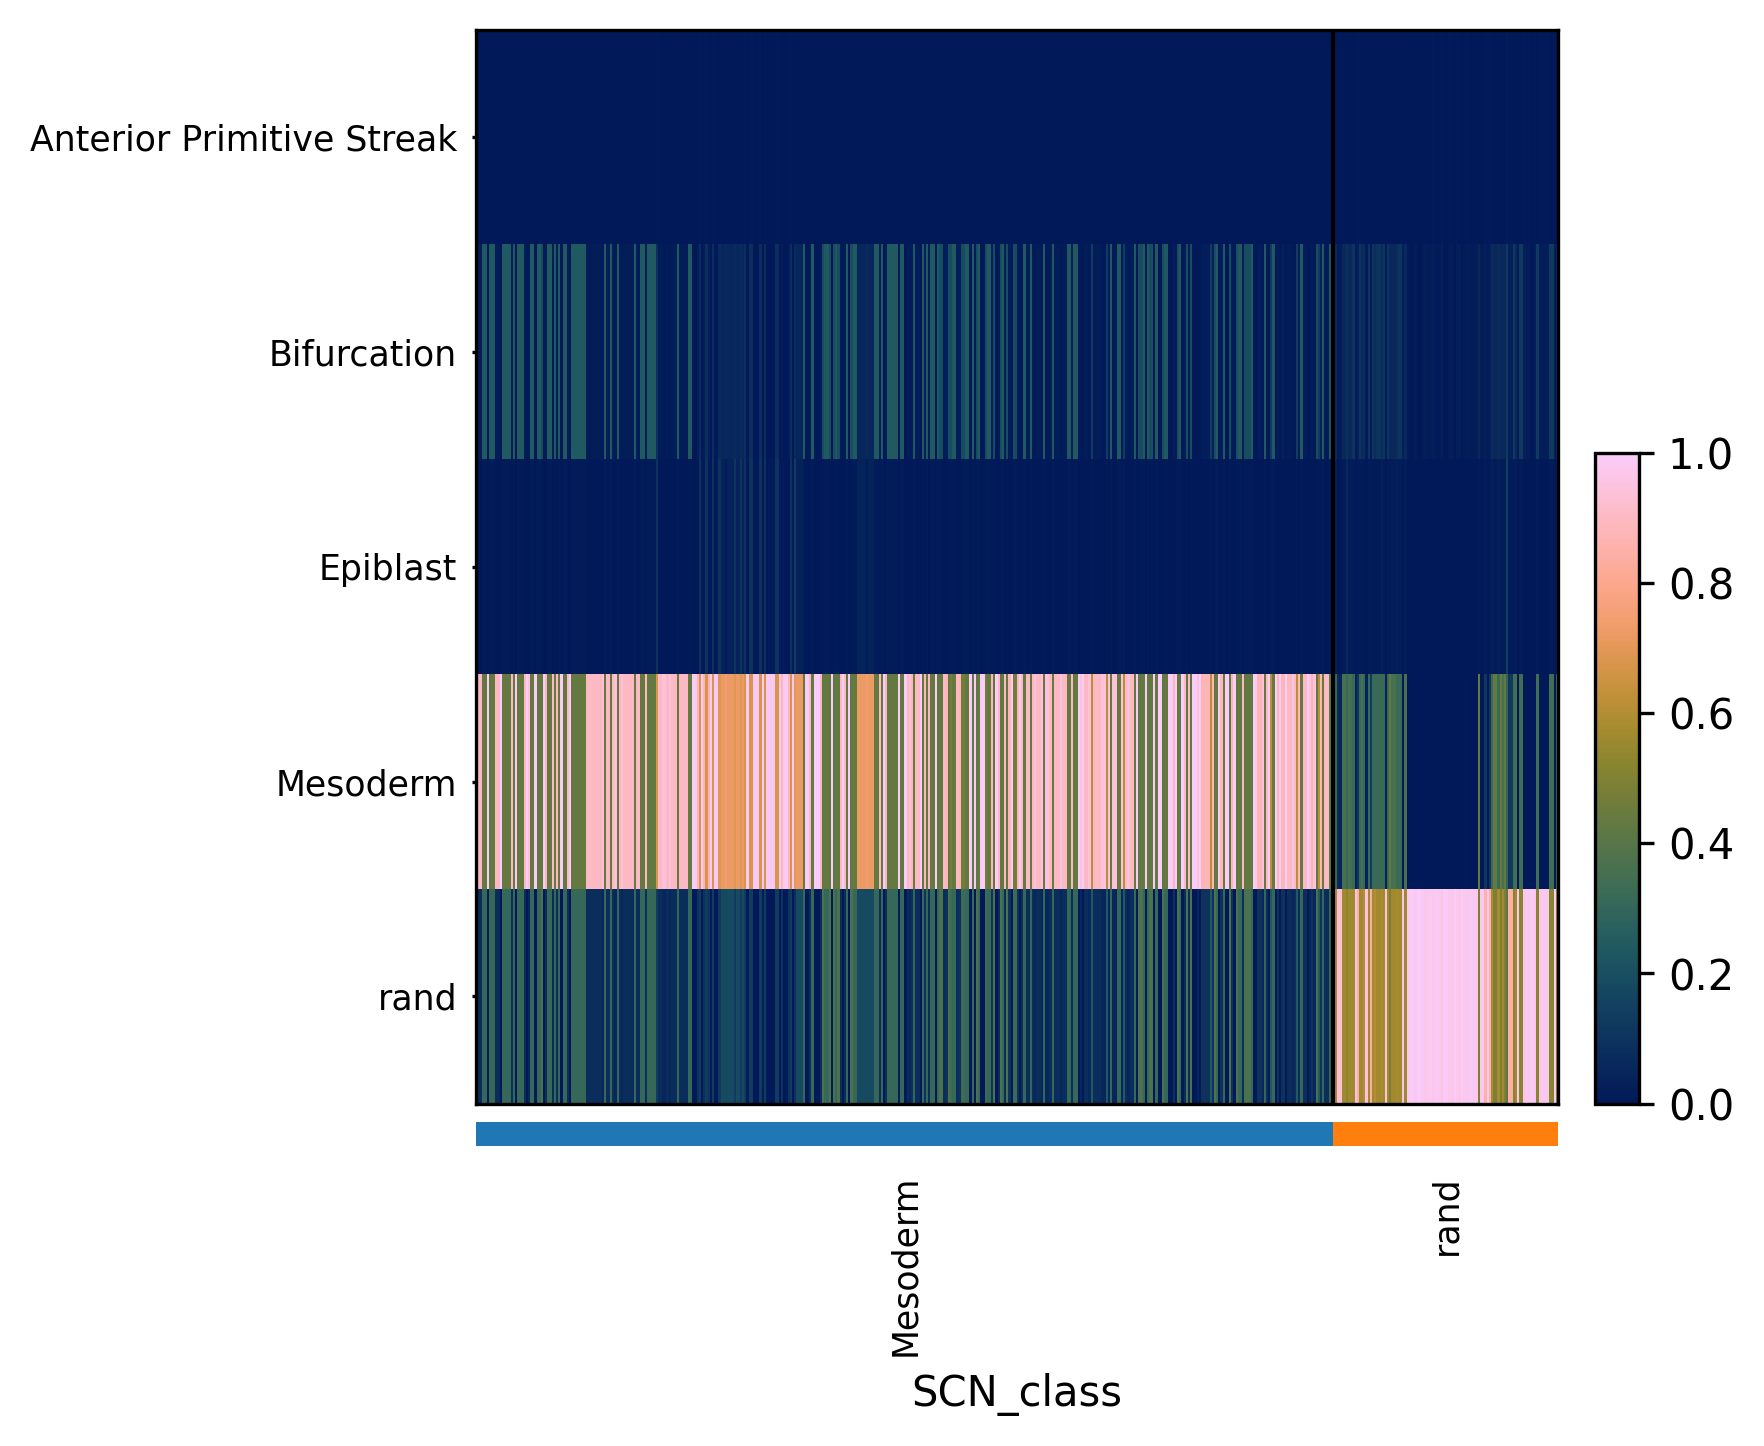

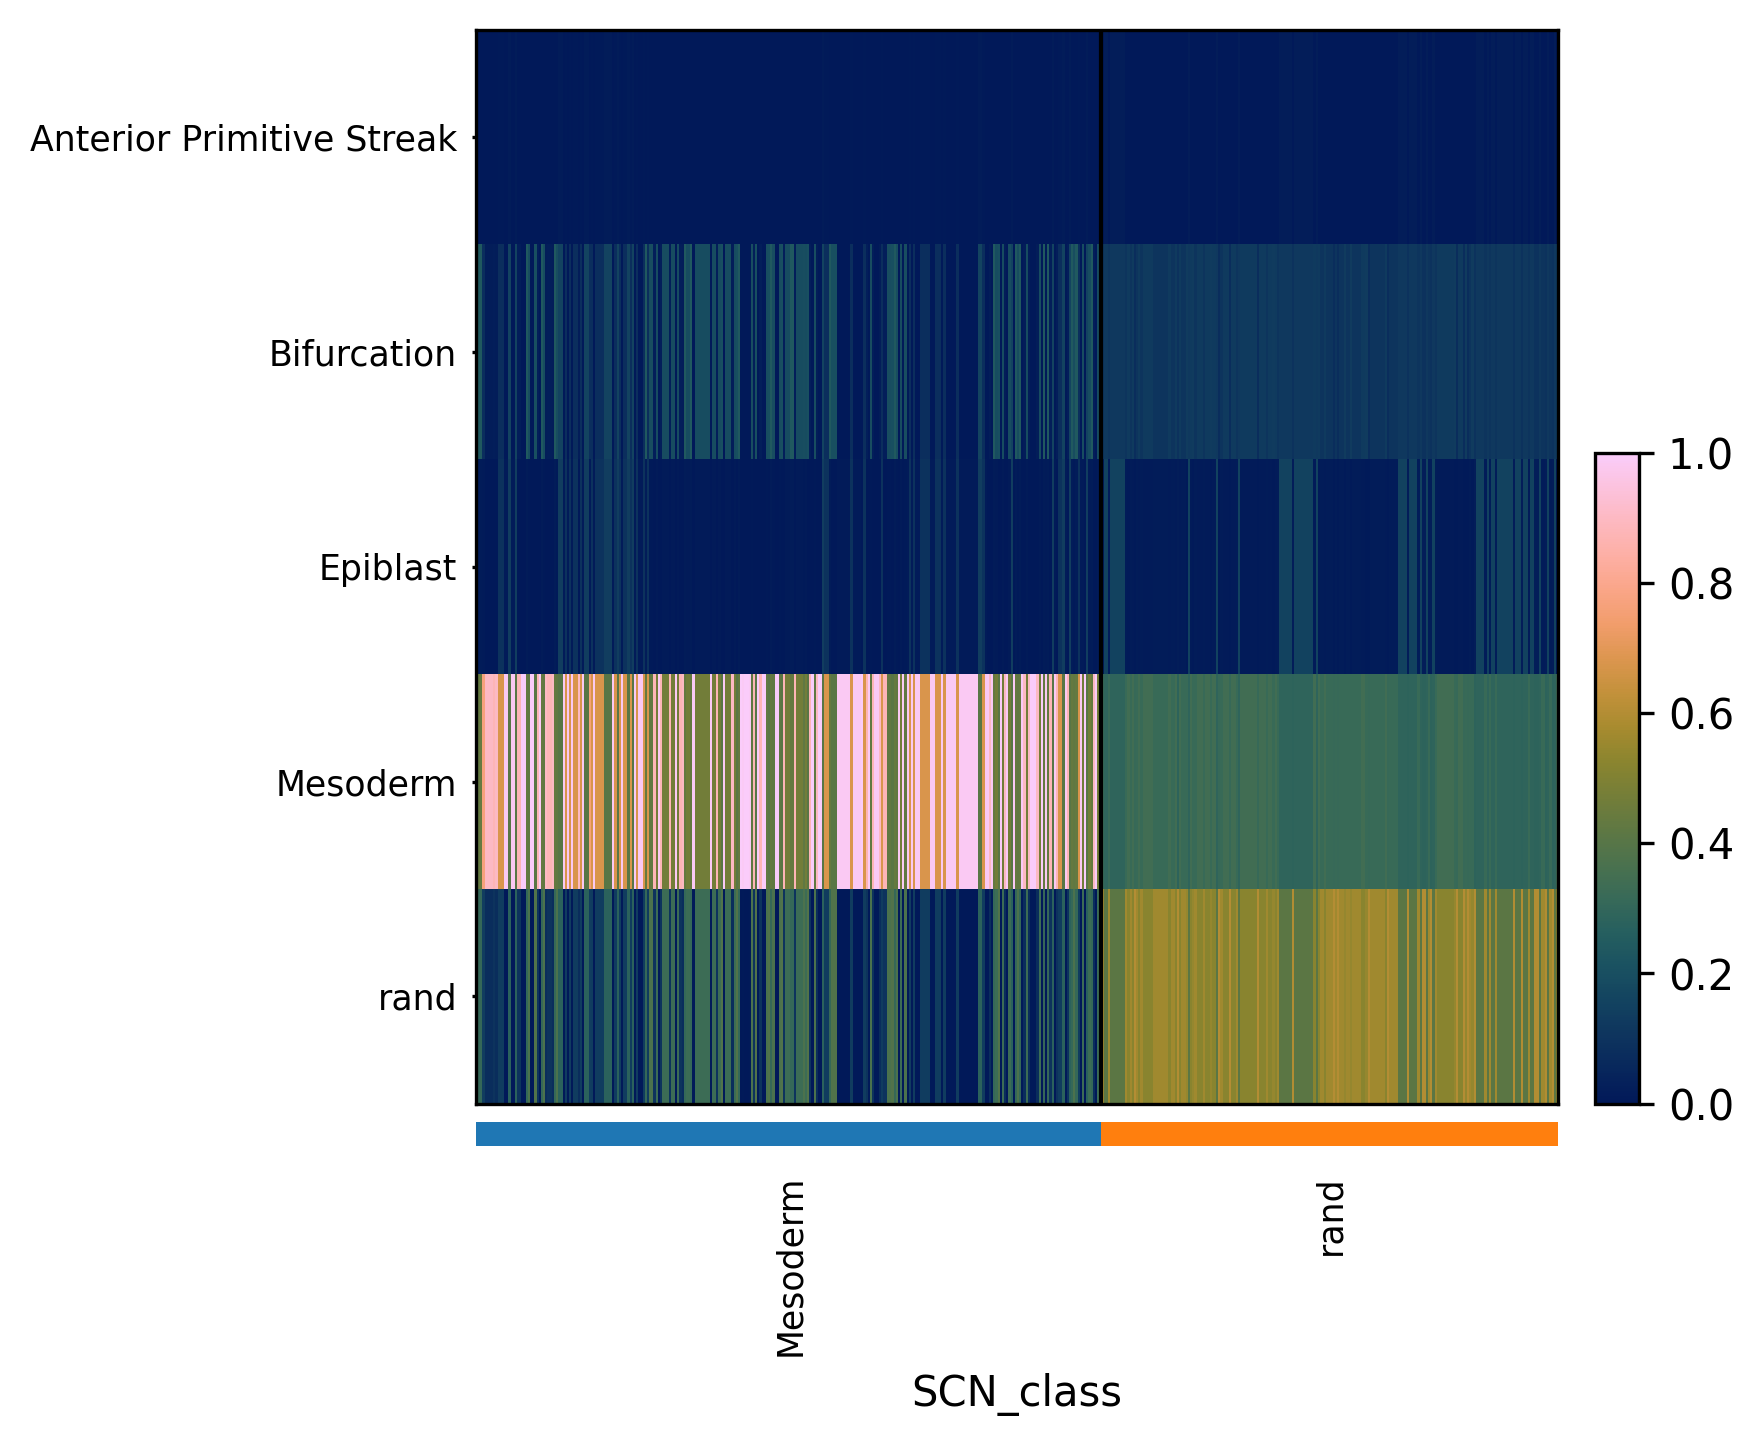

In [105]:
ads = []
for tf in tfs:
    perturb_dict = dict()
    perturb_dict[tf] = -1 
    simlist = onesc.simulate_parallel_adata(sim, xstates, netname, perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)
    ad = onesc.sample_and_compile_anndatas(simlist, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
    ads.append(ad)
    pySCN.rank_classify(ad, clf)
    pySCN.heatmap_scores(ad, groupby = 'SCN_class')

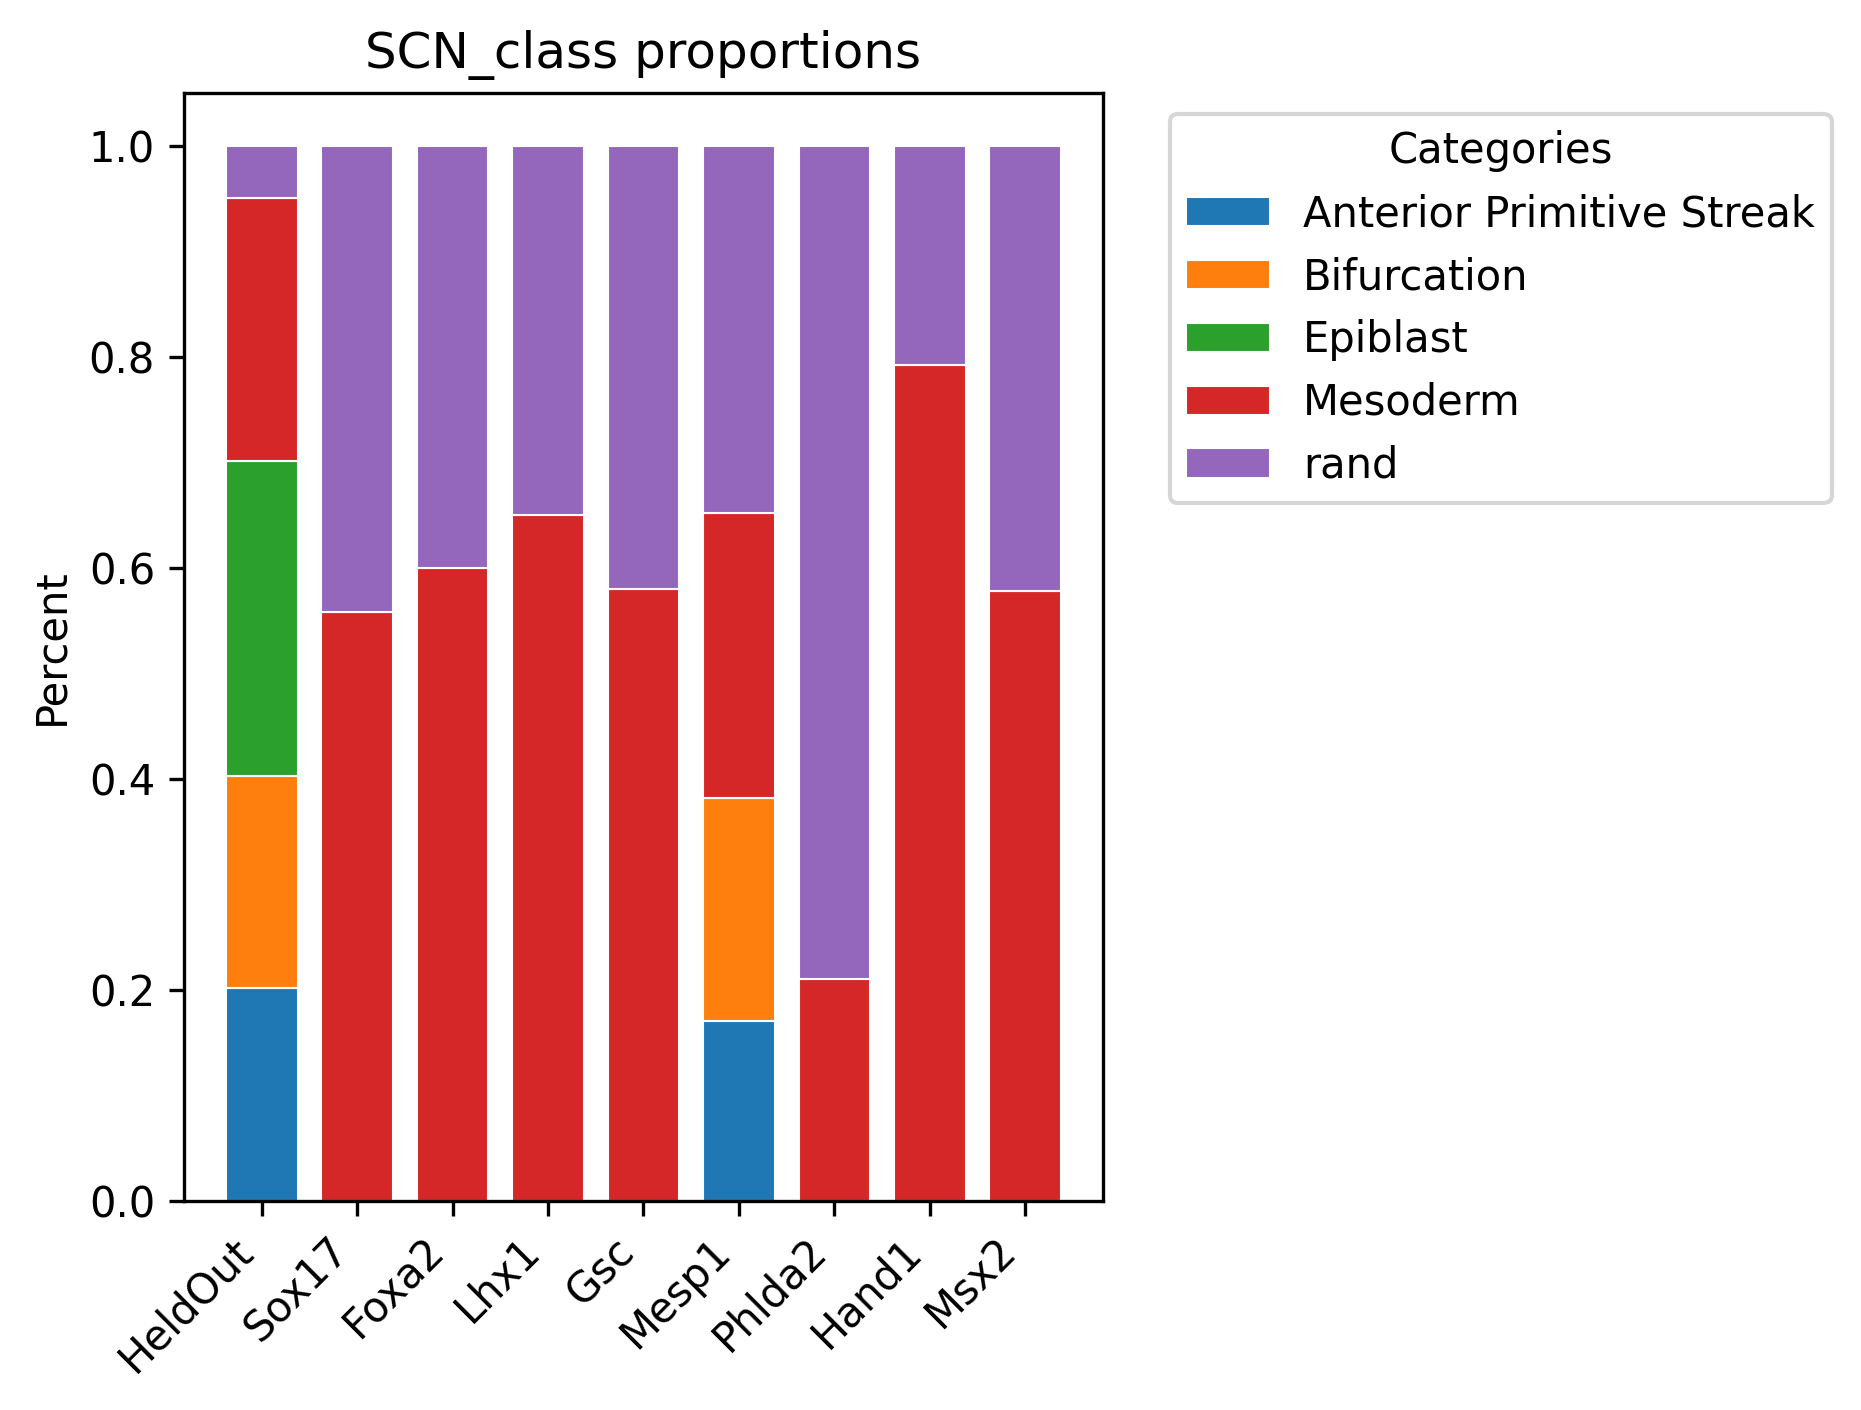

In [106]:
pySCN.plot_cell_type_proportions([adHeldOut_rank, *ads], obs_column = "SCN_class", labels=["HeldOut", *tfs])

Knocking out Hand1 seems to have produced the most Mesoderm cells while knocking out Phlda2 seems to have produced the most APS cells. 